# Подключение библиотеки

In [23]:
import timeit
import time
import sys
import os
import re
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from scipy import stats as st
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Многозадачная регрессия
from sklearn.multioutput import MultiOutputRegressor
# Для машинного обучения
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
# Метод ближайшего соседа KNN
from sklearn.neighbors import KNeighborsRegressor
# Метод опорного вектора, SVR - для регрессии
from sklearn.svm import SVR

# Метрики
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

# Нейросети
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
# Для сборщика мусора
import gc

# Импорт и анализ данных

In [2]:
df = pd.read_csv('Amp_C_train.txt')

##### Рассмотрим содержимое датасет

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


In [4]:
# Приведение к нижнему регистру названия колонки
df.columns = df.columns.str.lower()

In [5]:
df.head()

time input                       output
0  0.000000e+00    0j    (1.0785e-42-9.30535e-43j)
1  5.000000e-09    0j   (4.00167e-44+4.80805e-45j)
2  1.000000e-08    0j   (5.73102e-46+1.23143e-45j)
3  1.500000e-08    0j  (-2.47356e-47+3.89672e-47j)
4  2.000000e-08    0j  (-1.56497e-48+2.91821e-51j)

# Предобработка данных

## Сделаем датасет в временной ряд

In [6]:
# Установка колонки 'time' в качестве индекса
df.set_index('time', inplace=True)

## Преобразование комплексных входных и выходных сигналов из строкового представления

In [7]:
df['input'] = df['input'].apply(lambda x: complex(x.strip('()').replace('i', 'j')))
df['output'] = df['output'].apply(lambda x: complex(x.strip('()').replace('i', 'j')))

## Изменим DataFrame с реальной и мнимой частями комплексных чисел

In [8]:
df['input_real'] = df['input'].apply(np.real)
df['input_imag'] = df['input'].apply(np.imag)
df['output_real'] = df['output'].apply(np.real)
df['output_imag'] = df['output'].apply(np.imag)

In [9]:
df.head()

input                                          output  \
time                                                                     
0.000000e+00  0.0+0.0j  1.078500e-42-9.305350e-                    43j   
5.000000e-09  0.0+0.0j  4.001670e-44+4.808050e-                    45j   
1.000000e-08  0.0+0.0j  5.731020e-46+1.231430e-                    45j   
1.500000e-08  0.0+0.0j -2.473560e-47+3.896720e-                    47j   
2.000000e-08  0.0+0.0j -1.564970e-48+2.918210e-                    51j   

              input_real  input_imag   output_real   output_imag  
time                                                              
0.000000e+00         0.0         0.0  1.078500e-42 -9.305350e-43  
5.000000e-09         0.0         0.0  4.001670e-44  4.808050e-45  
1.000000e-08         0.0         0.0  5.731020e-46  1.231430e-45  
1.500000e-08         0.0         0.0 -2.473560e-47  3.896720e-47  
2.000000e-08         0.0         0.0 -1.564970e-48  2.918210e-51

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172032 entries, 0.0 to 0.000860155
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype     
---  ------       --------------   -----     
 0   input        172032 non-null  complex128
 1   output       172032 non-null  complex128
 2   input_real   172032 non-null  float64   
 3   input_imag   172032 non-null  float64   
 4   output_real  172032 non-null  float64   
 5   output_imag  172032 non-null  float64   
dtypes: complex128(2), float64(4)
memory usage: 11.8 MB


In [11]:
df = df.drop(['input', 'output'], axis=1)

In [12]:
df.describe()

input_real     input_imag    output_real    output_imag
count  172032.000000  172032.000000  172032.000000  172032.000000
mean        0.000053      -0.000013      -0.001947      -0.000626
std         0.592007       0.593872       2.087976       2.087590
min        -2.229120      -2.202991      -3.449150      -3.441910
25%        -0.399091      -0.399775      -1.934853      -1.937512
50%        -0.000685      -0.000342      -0.010191       0.004920
75%         0.398777       0.401744       1.935345       1.929125
max         2.212461       2.192265       3.451210       3.460060

## График

In [13]:
def draw_plot_signal(signal_type, time_start=0, time_end=1e-6):
    # Фильтрация данных по временной отметке
    filtered_data = df[(df.index >= time_start) & (df.index <= time_end)]
    time = filtered_data.index

    # Построение объединенного графика
    plt.figure(figsize=(10, 6))
    
    # Входной сигнал
    plt.plot(time, filtered_data[f'{signal_type}_real'], label=f'{signal_type} Real Part', color='blue', linestyle='-')
    plt.plot(time, filtered_data[f'{signal_type}_imag'], label=f'{signal_type} Imaginary Part', color='red', linestyle='-')
    
    plt.title('Input and Output Signals')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def draw_all_plot_signal(time_start=0, time_end=1e-6):
    # Фильтрация данных по временной отметке
    filtered_data = df[(df.index >= time_start) & (df.index <= time_end)]
    time = filtered_data.index
    
    plt.figure(figsize=(15, 10))

    # График реальной части входного сигнала
    plt.subplot(2, 2, 1)
    plt.plot(time, filtered_data['input_real'], label='Real Part')
    plt.title('Real Part of input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График мнимой части входного сигнала
    plt.subplot(2, 2, 2)
    plt.plot(time, filtered_data['input_imag'], label='Imaginary Part', color='orange')
    plt.title('Imaginary Part of input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График реальной части выходного сигнала
    plt.subplot(2, 2, 3)
    plt.plot(time, filtered_data['output_real'], label='Real Part')
    plt.title('Real Part of output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График мнимой части выходного сигнала
    plt.subplot(2, 2, 4)
    plt.plot(time, filtered_data['output_imag'], label='Imaginary Part', color='orange')
    plt.title('Imaginary Part of output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

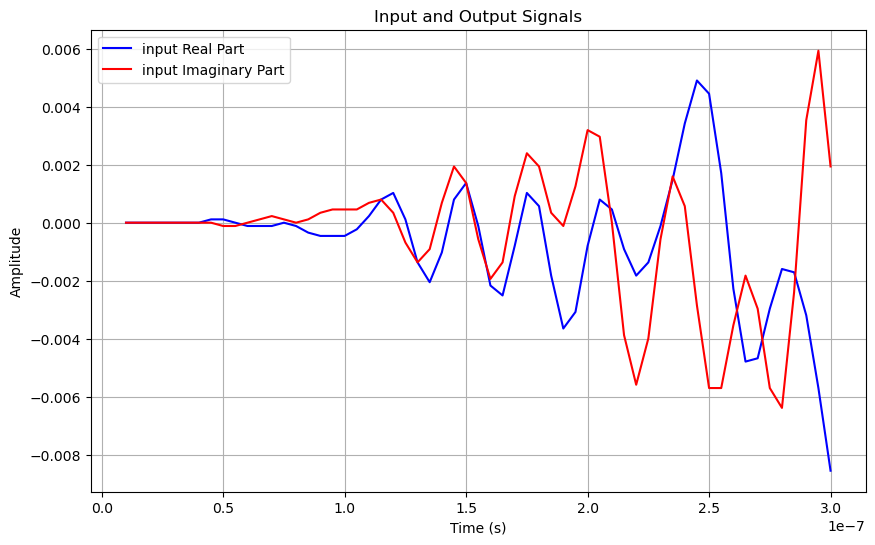

In [15]:
draw_plot_signal('input', time_start=1e-8, time_end=0.3e-6)

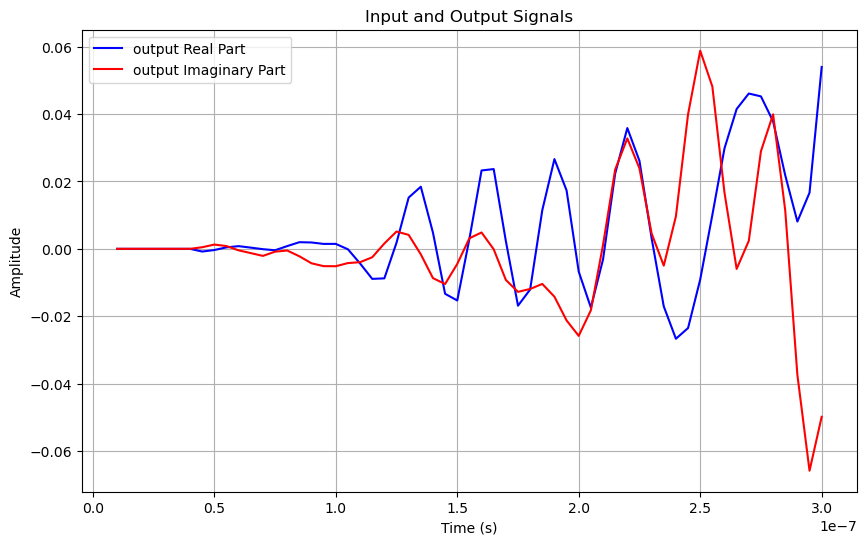

In [16]:
draw_plot_signal('output', time_start=1e-8, time_end=0.3e-6)

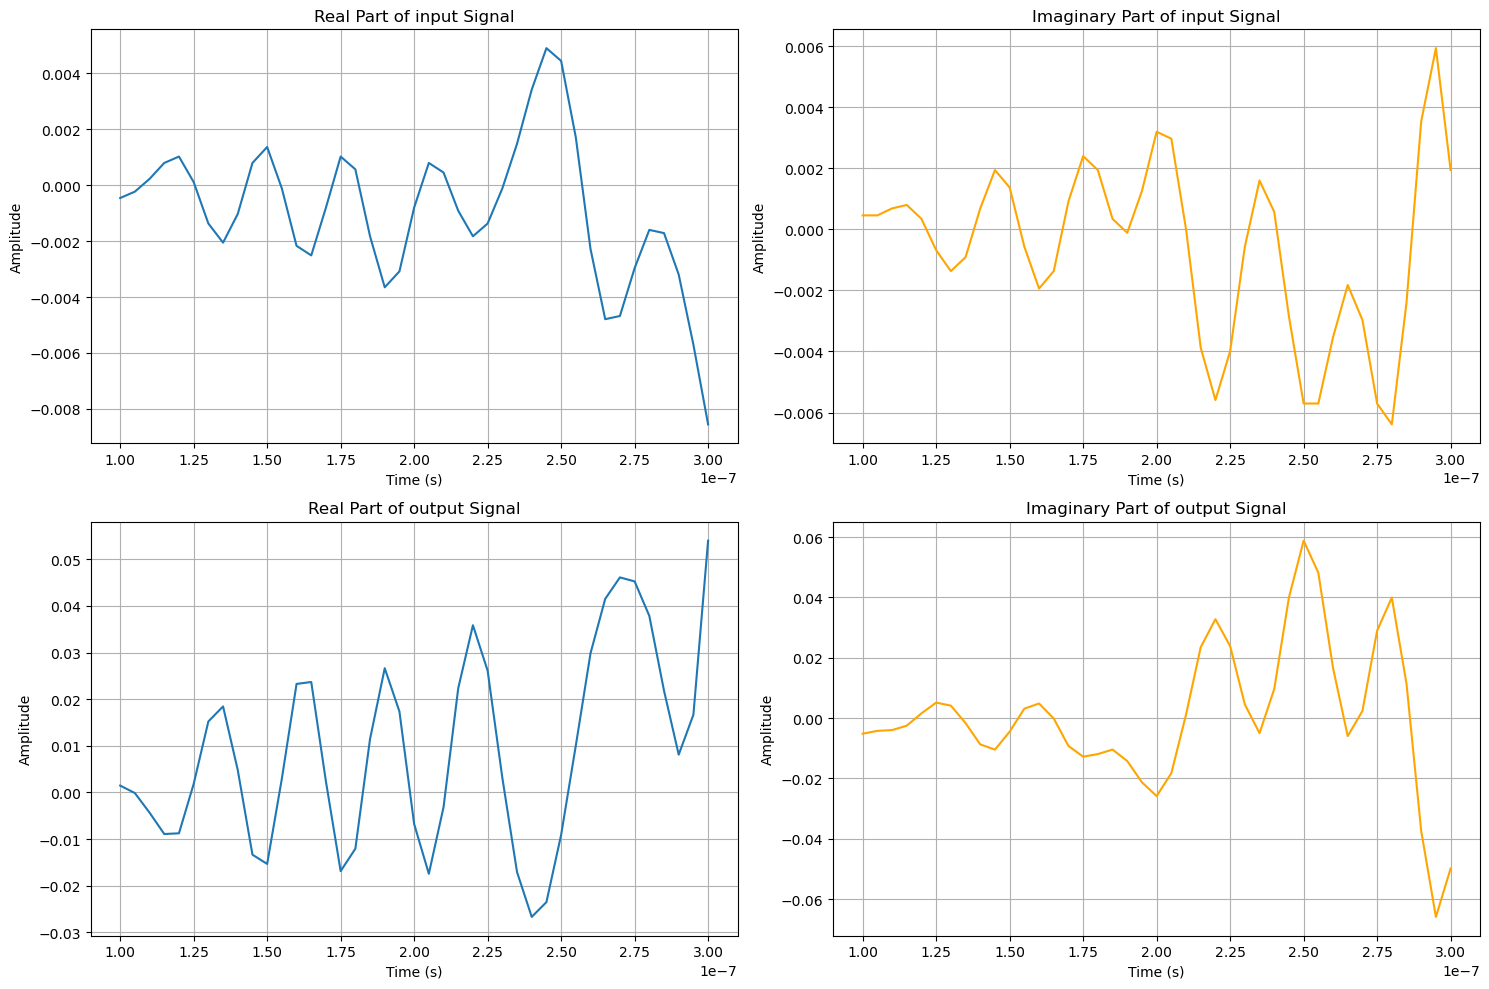

In [17]:
draw_all_plot_signal(time_start=1e-7, time_end=0.3e-6)

# Нейронное обучение

In [18]:
# Здесь будем сохранить результаты обучения
results = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

Сложные динамические NN-модели можно разделить на три основных архитектурных класса следующим образом:

1. Complex Time Delay Recurrent Neural Network (CTRNN).
2. Complex Time Delay Neural Network (CTDNN).
3. Real Valued Time delay Recurrent Neural Network (RVTDRNN).
4. Real Valued Time Delay Neural Network (RVTDNN), also named as the Real
Valued Focused Time Delay Neural Network (RVFTDNN).

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172032 entries, 0.0 to 0.000860155
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   input_real   172032 non-null  float64
 1   input_imag   172032 non-null  float64
 2   output_real  172032 non-null  float64
 3   output_imag  172032 non-null  float64
dtypes: float64(4)
memory usage: 6.6 MB


In [20]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is not available. Running on CPU.


/home/redalexdad/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Сложные динамические NN-модели

### Complex Time Delay Recurrent Neural Network (CTRNN)

In [21]:
# Функция для создания временных окон с задержками для входа и выхода
def create_time_delays_with_feedback(X_real, X_imag, Y_real, Y_imag, p, q):
    X_delayed = []
    Y_delayed = []
    
    for i in range(max(p, q), len(X_real)):
        # Входные задержки для X_real и X_imag
        X_real_window = X_real.iloc[i-p:i+1].values  # Входные задержки (x(k), x(k-1), ..., x(k-p))
        X_imag_window = X_imag.iloc[i-p:i+1].values
        
        # Обратная связь для Y_real и Y_imag
        Y_real_window = Y_real.iloc[i-q:i].values  # Обратная связь (y(k-1), y(k-2), ..., y(k-q))
        Y_imag_window = Y_imag.iloc[i-q:i].values
        
        # Комбинируем вещественные и мнимые части
        X_combined = np.concatenate([X_real_window, X_imag_window, Y_real_window, Y_imag_window])
        
        X_delayed.append(X_combined)
        
        # Текущие значения выходных данных
        Y_combined = np.array([Y_real.iloc[i], Y_imag.iloc[i]])
        Y_delayed.append(Y_combined)
    
    return np.array(X_delayed), np.array(Y_delayed)

In [22]:
# Параметры задержек (p и q)
p = 10  # Входная задержка
q = 5   # Выходная задержка

In [23]:
%%time
# Создание временных последовательностей с задержками и обратной связью
X_seq, Y_seq = create_time_delays_with_feedback(
    df['input_real'], 
    df['input_imag'], 
    df['output_real'], 
    df['output_imag'], 
    p, q
)

CPU times: user 13.3 s, sys: 3.48 s, total: 16.8 s
Wall time: 12.4 s


In [24]:
# Нормализация данных
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_seq)
Y_scaled = scaler_Y.fit_transform(Y_seq)

In [25]:
# Преобразование данных в тензоры PyTorch с добавлением временного измерения
X_train_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1).to(device)  # Добавляем временное измерение и переносим на device
Y_train_tensor = torch.tensor(Y_scaled, dtype=torch.float32).to(device)

In [26]:
# Создание DataLoader для мини-батчей
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [27]:
# Определение модели CTDRNN
class CTDRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CTDRNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Используем последний временной шаг
        return out

In [32]:
class CTDRNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, num_layers):
        super(CTDRNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size1, num_layers=num_layers, 
                            batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size1 * 2, hidden_size1)  # Увеличиваем вход из-за bidirectional LSTM
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)       # Дополнительный скрытый слой
        self.fc3 = nn.Linear(hidden_size2, output_size)        # Финальный слой
        self.relu = nn.ReLU()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.relu(self.fc1(lstm_out[:, -1, :]))  # Активация после первого полносвязного слоя
        x = self.relu(self.fc2(x))                   # Активация после второго полносвязного слоя
        out = self.fc3(x)                            # Финальный полносвязный слой
        return out

In [28]:
class CTDRNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, num_layers):
        super(CTDRNN, self).__init__()
        # Bidirectional LSTM с несколькими слоями
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size1, num_layers=num_layers, 
                            batch_first=True, bidirectional=True, dropout=0.3)
        # Дополнительные полносвязные слои
        self.fc1 = nn.Linear(hidden_size1 * 2, hidden_size2)  # Увеличиваем размер входа из-за bidirectional LSTM
        self.fc2 = nn.Linear(hidden_size2, hidden_size3)       # Дополнительный скрытый слой
        self.fc3 = nn.Linear(hidden_size3, output_size)        # Финальный слой
        self.relu = nn.ReLU()
        self.layer_norm = nn.LayerNorm(hidden_size2)  # Нормализация слоя для улучшения стабильности
        self.dropout = nn.Dropout(0.3)  # Добавление Dropout для регуляризации
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.relu(self.fc1(lstm_out[:, -1, :]))  # Активация после первого полносвязного слоя
        x = self.layer_norm(x)                       # Нормализация слоя
        x = self.dropout(x)                          # Dropout для предотвращения переобучения
        x = self.relu(self.fc2(x))                   # Активация после второго полносвязного слоя
        out = self.fc3(x)                            # Финальный полносвязный слой
        return out

In [33]:
# Параметры модели
input_size = 2 * (p + 1 + q)  # Входные и выходные задержки (вещественная и мнимая части)
hidden_size1, hidden_size2, hidden_size3 = 100, 100, 100
output_size = 2  # Вещественная и мнимая часть выходного сигнала
num_layers = 2
num_epochs = 100
learning_rate = 0.001

In [34]:
# Инициализация модели, функции потерь и оптимизатора
model = CTDRNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
%%time
# Список для хранения значений функции потерь
loss_values = []

# Задержка для измерения времени
start_time = time.time()

# Обучение модели
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, Y_batch in train_loader:
        # Перенос батчей на GPU
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  
        
        # Прямой проход
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        
        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * X_batch.size(0)  # Умножаем на размер батча для подсчета средней потери

    # Сохраняем среднее значение функции потерь для текущей эпохи
    avg_loss = epoch_loss / len(train_loader.dataset)
    loss_values.append(avg_loss)

    # if (epoch+1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

end_time = time.time()
elapsed = end_time - start_time

Epoch [1/100], Loss: 0.026403
Epoch [2/100], Loss: 0.007639
Epoch [3/100], Loss: 0.004398
Epoch [4/100], Loss: 0.003203
Epoch [5/100], Loss: 0.002455
Epoch [6/100], Loss: 0.002052
Epoch [7/100], Loss: 0.001814
Epoch [8/100], Loss: 0.001624
Epoch [9/100], Loss: 0.001501
Epoch [10/100], Loss: 0.001403
Epoch [11/100], Loss: 0.001308
Epoch [12/100], Loss: 0.001244
Epoch [13/100], Loss: 0.001175
Epoch [14/100], Loss: 0.001128
Epoch [15/100], Loss: 0.001080
Epoch [16/100], Loss: 0.001048
Epoch [17/100], Loss: 0.001010
Epoch [18/100], Loss: 0.000981
Epoch [19/100], Loss: 0.000945
Epoch [20/100], Loss: 0.000926
Epoch [21/100], Loss: 0.000908
Epoch [22/100], Loss: 0.000876
Epoch [23/100], Loss: 0.000862
Epoch [24/100], Loss: 0.000843
Epoch [25/100], Loss: 0.000817
Epoch [26/100], Loss: 0.000804
Epoch [27/100], Loss: 0.000790
Epoch [28/100], Loss: 0.000769
Epoch [29/100], Loss: 0.000759
Epoch [30/100], Loss: 0.000759
Epoch [31/100], Loss: 0.000745
Epoch [32/100], Loss: 0.000729
Epoch [33/100], L

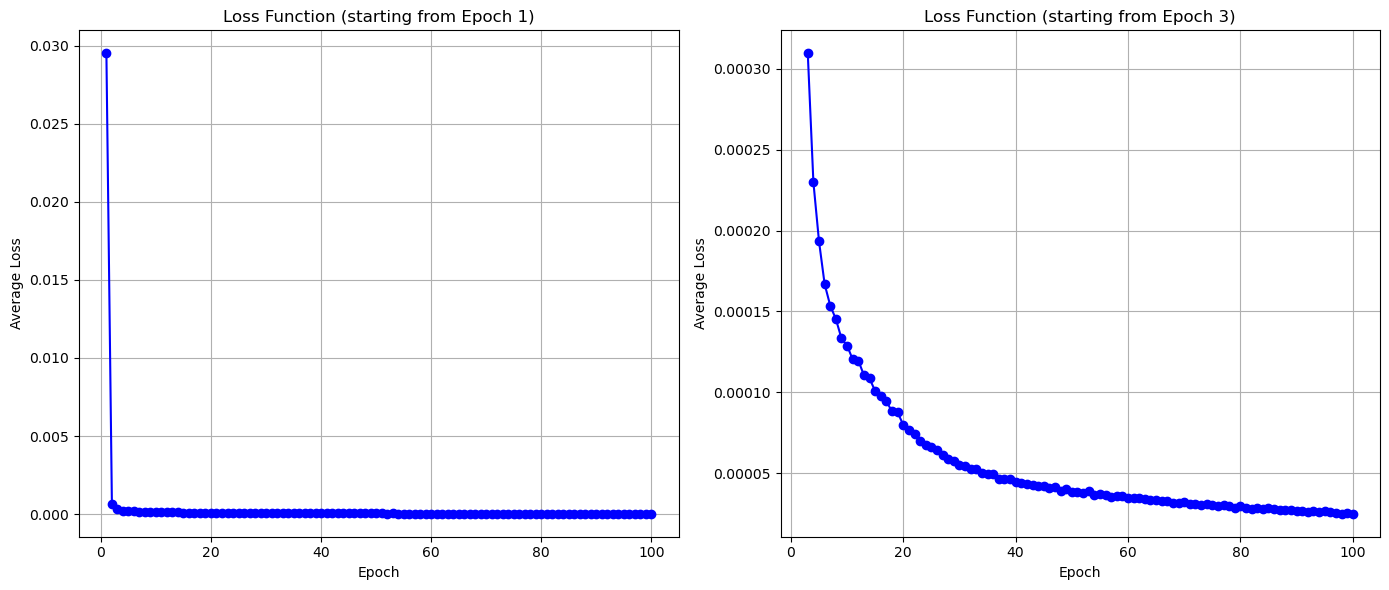

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Первый график
epoch_start = 1
axs[0].plot(range(epoch_start, num_epochs + 1), loss_values[epoch_start-1:], marker='o', linestyle='-', color='b')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Average Loss')
axs[0].set_title('Loss Function (starting from Epoch 1)')
axs[0].grid(True)

# Второй график
epoch_start = 3
axs[1].plot(range(epoch_start, num_epochs + 1), loss_values[epoch_start-1:], marker='o', linestyle='-', color='b')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Average Loss')
axs[1].set_title(f'Loss Function (starting from Epoch {epoch_start})')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [32]:
# Оценка модели
model.eval()  # Переключение в режим оценки
with torch.no_grad():
    Y_pred_scaled = model(X_train_tensor).cpu().numpy()
    Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
    rmse_real = np.sqrt(mean_squared_error(Y_seq[:, 0], Y_pred[:, 0]))
    rmse_imag = np.sqrt(mean_squared_error(Y_seq[:, 1], Y_pred[:, 1]))

print(f'RMSE (Real part): {rmse_real}')
print(f'RMSE (Imaginary part): {rmse_imag}')

RMSE (Real part): 0.010985768863937656
RMSE (Imaginary part): 0.010003567812806704


In [33]:
# Заполнение результатов
results[count_model] = pd.Series({
    'NAME': 'CTDRNN',  # Название модели
    'RMSE TRAIN': None,
    'RMSE VALID REAL': rmse_real,
    'RMSE VALID IMAG': rmse_imag,
    'TIME TRAINING [s]': elapsed,
    'TIME PREDICTION [s]': None,
    'PREDICTIONS': Y_pred,
    'PARAMETRS': model.state_dict()  # Хранение параметров модели
})

display(results[count_model])
count_model += 1

NAME                                                              CTDRNN
RMSE TRAIN                                                          None
RMSE VALID REAL                                                 0.010986
RMSE VALID IMAG                                                 0.010004
TIME TRAINING [s]                                             734.214262
TIME PREDICTION [s]                                                 None
PREDICTIONS            [[0.008708529, 0.0060001696], [0.009501646, 0....
PARAMETRS              {'lstm.weight_ih_l0': [[tensor(-0.0367, device...
Name: 0, dtype: object

##### Сохранение модели после обучения

In [34]:
# После завершения обучения
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': loss.item(),
}, 'ctrdnn_model.pth')

In [35]:
# Пример структуры DataFrame для info_result:
# Создание DataFrame с реальными и предсказанными значениями
info_result = pd.DataFrame({
    'default_real': Y_seq[:, 0],  # Реальные значения (вещественная часть)
    'default_imag': Y_seq[:, 1],  # Реальные значения (мнимая часть)
    'pred_real': Y_pred[:, 0],    # Предсказанные значения (вещественная часть)
    'pred_imag': Y_pred[:, 1]     # Предсказанные значения (мнимая часть)
})

# Если у вас есть временные метки:
info_result.index = range(len(Y_seq))  # Пример временной шкалы: индексы от 0 до количества наблюдений

In [36]:
def plot_predictions_vs_real(info_result, time_start, time_end):
    # Фильтрация данных по временной отметке
    filtered_data = info_result[(info_result.index >= time_start) & (info_result.index <= time_end)]
    time = filtered_data.index

    # Создание фигуры с двумя подграфиками
    fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
    
    # Общий заголовок для всей фигуры
    fig.suptitle('Comparison of Real and Predicted Values', fontsize=22)

    # Построение графиков реальных и предсказанных значений (вещественная часть)
    axs[0].plot(time, filtered_data['default_real'], alpha=0.7, color='red', lw=2.5, label='Real (default)')
    axs[0].plot(time, filtered_data['pred_real'], alpha=0.7, color='blue', lw=2.5, label='Predicted')
    axs[0].legend(fontsize='xx-large')
    axs[0].grid()
    axs[0].set_xlabel('Time', fontsize=20)
    axs[0].set_ylabel('Real Part', fontsize=20)
    axs[0].set_title('Real Part: Default vs Predicted', fontsize=20)

    # Построение графиков реальных и предсказанных значений (мнимая часть)
    axs[1].plot(time, filtered_data['default_imag'], alpha=0.7, color='red', lw=2.5, label='Real (default)')
    axs[1].plot(time, filtered_data['pred_imag'], alpha=0.7, color='blue', lw=2.5, label='Predicted')
    axs[1].legend(fontsize='xx-large')
    axs[1].grid()
    axs[1].set_xlabel('Time', fontsize=20)
    axs[1].set_ylabel('Imaginary Part', fontsize=20)
    axs[1].set_title('Imaginary Part: Default vs Predicted', fontsize=20)

    # Показываем график
    plt.tight_layout()
    plt.show()

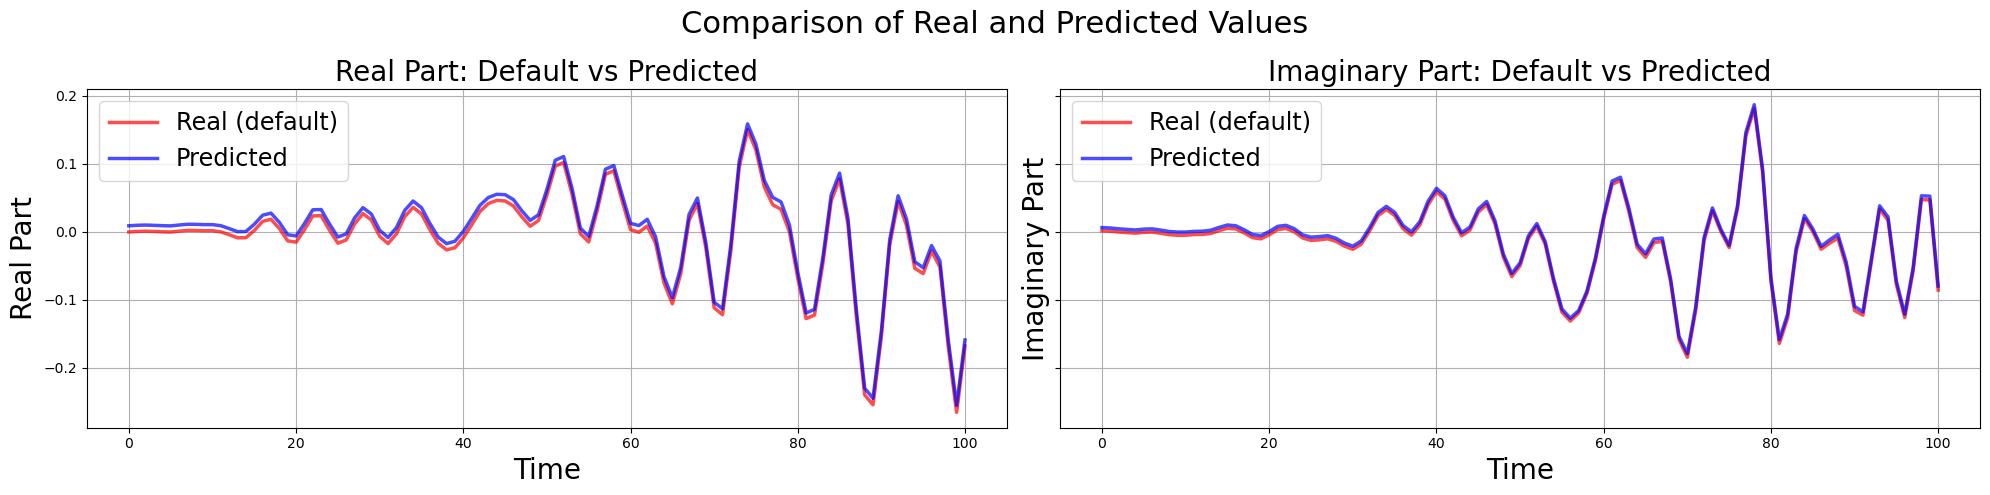

In [37]:
plot_predictions_vs_real(info_result, time_start=0, time_end=1.005e2)

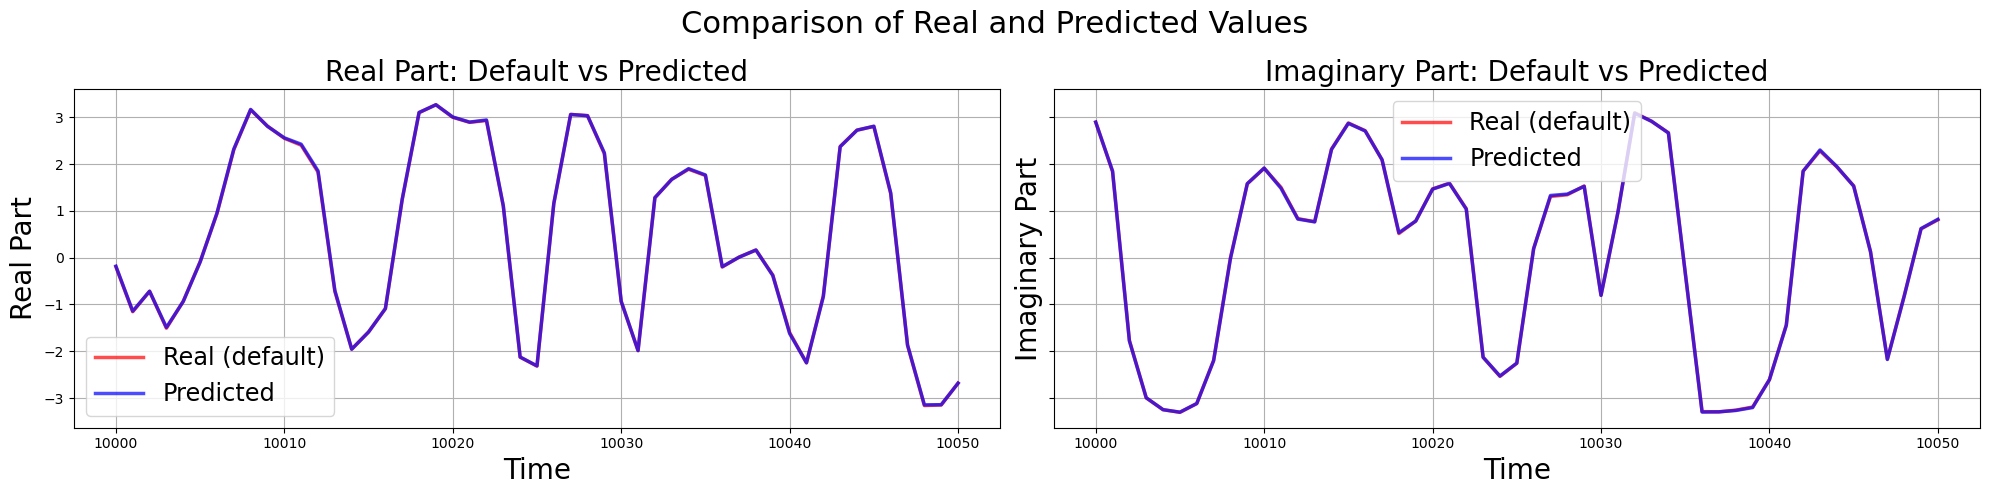

In [38]:
plot_predictions_vs_real(info_result, time_start=1e4, time_end=1.005e4)

### Complex Time Delay Neural Network (CTDNN)

In [21]:
# Функция для создания входных данных с задержкой
def create_time_delayed_inputs(X_real, X_imag, p):
    X_delayed = []
    
    for i in range(p, len(X_real)):
        # Формируем задержки для комплексных данных
        X_real_window = X_real.iloc[i-p:i+1].values  # Вещественная часть
        X_imag_window = X_imag.iloc[i-p:i+1].values  # Мнимая часть
        
        # Комбинируем вещественные и мнимые части
        X_combined = np.concatenate([X_real_window, X_imag_window])
        X_delayed.append(X_combined)
    
    return np.array(X_delayed)

In [22]:
# Функция для создания выходных данных
def create_outputs(Y_real, Y_imag, p):
    Y_delayed = []
    
    for i in range(p, len(Y_real)):
        # Текущие значения выходных данных (реальная и мнимая части)
        Y_combined = np.array([Y_real.iloc[i], Y_imag.iloc[i]])
        Y_delayed.append(Y_combined)
    
    return np.array(Y_delayed)

In [23]:
# Параметры задержки p
p = 10  # Входная задержка

In [24]:
%%time
# Создание временных последовательностей с задержками и обратной связью
X_seq = create_time_delayed_inputs(
    df['input_real'], 
    df['input_imag'], 
    p
)

CPU times: user 5.46 s, sys: 629 ms, total: 6.09 s
Wall time: 5.38 s


In [25]:
%%time
# Создаем выходные данные
Y_seq = create_outputs(
    df['output_real'], 
    df['output_imag'], 
    p
)

CPU times: user 1.15 s, sys: 11.5 ms, total: 1.16 s
Wall time: 1.16 s


In [26]:
# Нормализация данных
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_seq)
Y_scaled = scaler_Y.fit_transform(Y_seq)

In [27]:
# Преобразование данных в тензоры PyTorch с добавлением временного измерения
X_train_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_scaled, dtype=torch.float32).to(device)

In [35]:
# Определение модели CTDNN (полносвязной сети)
class CTDNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(CTDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [39]:
class CTDNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(CTDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))         # Первый слой с ReLU
        x = self.leaky_relu(self.fc2(x))   # Второй слой с LeakyReLU
        x = self.relu(self.fc3(x))         # Третий слой с ReLU
        x = self.leaky_relu(self.fc4(x))   # Четвертый слой с LeakyReLU
        out = self.fc5(x)                  # Выходной слой без активации
        return out

In [40]:
# Параметры модели
input_size = 2 * (p + 1)  # Входные задержки (вещественная и мнимая части)
hidden_size1, hidden_size2, hidden_size3, hidden_size4 = 100, 200, 200, 100
output_size = 2  # Вещественная и мнимая часть выходного сигнала
num_epochs = 10000

In [41]:
# Инициализация модели, функции потерь и оптимизатора
model = CTDNN(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
%%time
# Список для хранения значений функции потерь
loss_values = []

# Задержка для измерения времени
start_time = time.time()

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    
    # Прямой проход
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    
    # Сохранение значения функции потерь
    loss_values.append(loss.item())
    
    # Обратное распространение и оптимизация
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

end_time = time.time()
elapsed = end_time - start_time

Epoch [100/10000], Loss: 0.027304
Epoch [200/10000], Loss: 0.008347
Epoch [300/10000], Loss: 0.003772
Epoch [400/10000], Loss: 0.002576
Epoch [500/10000], Loss: 0.003888
Epoch [600/10000], Loss: 0.001580
Epoch [700/10000], Loss: 0.001579
Epoch [800/10000], Loss: 0.001075
Epoch [900/10000], Loss: 0.000932
Epoch [1000/10000], Loss: 0.000865
Epoch [1100/10000], Loss: 0.000719
Epoch [1200/10000], Loss: 0.000648
Epoch [1300/10000], Loss: 0.001265
Epoch [1400/10000], Loss: 0.000529
Epoch [1500/10000], Loss: 0.000620
Epoch [1600/10000], Loss: 0.000441
Epoch [1700/10000], Loss: 0.000413
Epoch [1800/10000], Loss: 0.000377
Epoch [1900/10000], Loss: 0.000353
Epoch [2000/10000], Loss: 0.002610
Epoch [2100/10000], Loss: 0.000308
Epoch [2200/10000], Loss: 0.000402
Epoch [2300/10000], Loss: 0.000271
Epoch [2400/10000], Loss: 0.000278
Epoch [2500/10000], Loss: 0.000243
Epoch [2600/10000], Loss: 0.000236
Epoch [2700/10000], Loss: 0.000218
Epoch [2800/10000], Loss: 0.000240
Epoch [2900/10000], Loss: 0.0

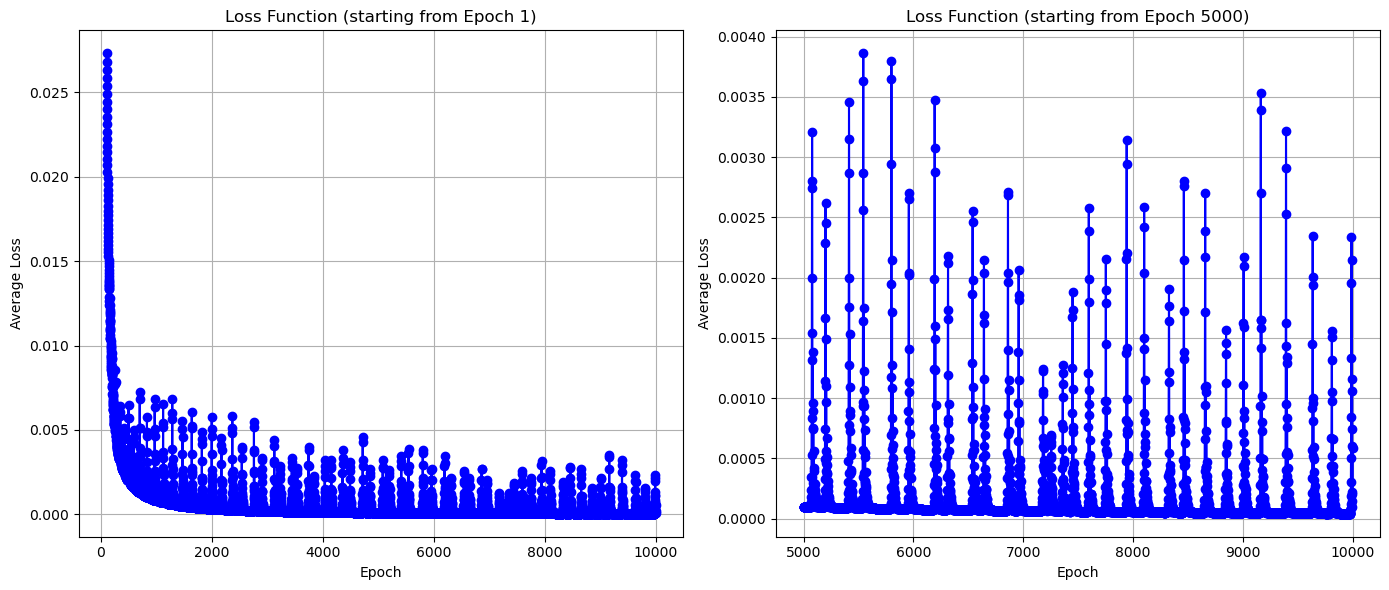

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Первый график
epoch_start = 100
axs[0].plot(range(epoch_start, num_epochs + 1), loss_values[epoch_start-1:], marker='o', linestyle='-', color='b')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Average Loss')
axs[0].set_title('Loss Function (starting from Epoch 1)')
axs[0].grid(True)

# Второй график
epoch_start = 5000
axs[1].plot(range(epoch_start, num_epochs + 1), loss_values[epoch_start-1:], marker='o', linestyle='-', color='b')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Average Loss')
axs[1].set_title(f'Loss Function (starting from Epoch {epoch_start})')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [44]:
# Оценка модели
model.eval()  # Переключение в режим оценки
with torch.no_grad():
    Y_pred_scaled = model(X_train_tensor).cpu().numpy()
    Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
    rmse_real = np.sqrt(mean_squared_error(Y_seq[:, 0], Y_pred[:, 0]))
    rmse_imag = np.sqrt(mean_squared_error(Y_seq[:, 1], Y_pred[:, 1]))

print(f'RMSE (Real part): {rmse_real}')
print(f'RMSE (Imaginary part): {rmse_imag}')

RMSE (Real part): 0.021007434401882644
RMSE (Imaginary part): 0.06543876381965509


In [45]:
# Заполнение результатов
results[count_model] = pd.Series({
    'NAME': 'CTDNN',  # Название модели
    'RMSE TRAIN': None,
    'RMSE VALID REAL': rmse_real,
    'RMSE VALID IMAG': rmse_imag,
    'TIME TRAINING [s]': elapsed,
    'TIME PREDICTION [s]': None,
    'PREDICTIONS': Y_pred,
    'PARAMETRS': model.state_dict()  # Хранение параметров модели
})

display(results[count_model])
count_model += 1

NAME                                                               CTDNN
RMSE TRAIN                                                          None
RMSE VALID REAL                                                 0.021007
RMSE VALID IMAG                                                 0.065439
TIME TRAINING [s]                                             875.996903
TIME PREDICTION [s]                                                 None
PREDICTIONS            [[-0.002230675, -0.07779023], [-0.001356136, -...
PARAMETRS              {'fc1.weight': [[tensor(0.0413, device='cuda:0...
Name: 0, dtype: object

##### Сохранение модели после обучения

In [46]:
# После завершения обучения
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': loss.item(),
}, 'ctdnn_model_0_02_real_0_06_imag.pth')

In [54]:
# Пример структуры DataFrame для info_result:
# Создание DataFrame с реальными и предсказанными значениями
info_result = pd.DataFrame({
    'default_real': Y_seq[:, 0],  # Реальные значения (вещественная часть)
    'default_imag': Y_seq[:, 1],  # Реальные значения (мнимая часть)
    'pred_real': Y_pred[:, 0],    # Предсказанные значения (вещественная часть)
    'pred_imag': Y_pred[:, 1]     # Предсказанные значения (мнимая часть)
})

# Если у вас есть временные метки:
info_result.index = range(len(Y_seq))  # Пример временной шкалы: индексы от 0 до количества наблюдений

In [55]:
def plot_predictions_vs_real(info_result, time_start, time_end):
    # Фильтрация данных по временной отметке
    filtered_data = info_result[(info_result.index >= time_start) & (info_result.index <= time_end)]
    time = filtered_data.index

    # Создание фигуры с двумя подграфиками
    fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
    
    # Общий заголовок для всей фигуры
    fig.suptitle('Comparison of Real and Predicted Values', fontsize=22)

    # Построение графиков реальных и предсказанных значений (вещественная часть)
    axs[0].plot(time, filtered_data['default_real'], alpha=0.7, color='red', lw=2.5, label='Real (default)')
    axs[0].plot(time, filtered_data['pred_real'], alpha=0.7, color='blue', lw=2.5, label='Predicted')
    axs[0].legend(fontsize='xx-large')
    axs[0].grid()
    axs[0].set_xlabel('Time', fontsize=20)
    axs[0].set_ylabel('Real Part', fontsize=20)
    axs[0].set_title('Real Part: Default vs Predicted', fontsize=20)

    # Построение графиков реальных и предсказанных значений (мнимая часть)
    axs[1].plot(time, filtered_data['default_imag'], alpha=0.7, color='red', lw=2.5, label='Real (default)')
    axs[1].plot(time, filtered_data['pred_imag'], alpha=0.7, color='blue', lw=2.5, label='Predicted')
    axs[1].legend(fontsize='xx-large')
    axs[1].grid()
    axs[1].set_xlabel('Time', fontsize=20)
    axs[1].set_ylabel('Imaginary Part', fontsize=20)
    axs[1].set_title('Imaginary Part: Default vs Predicted', fontsize=20)

    # Показываем график
    plt.tight_layout()
    plt.show()

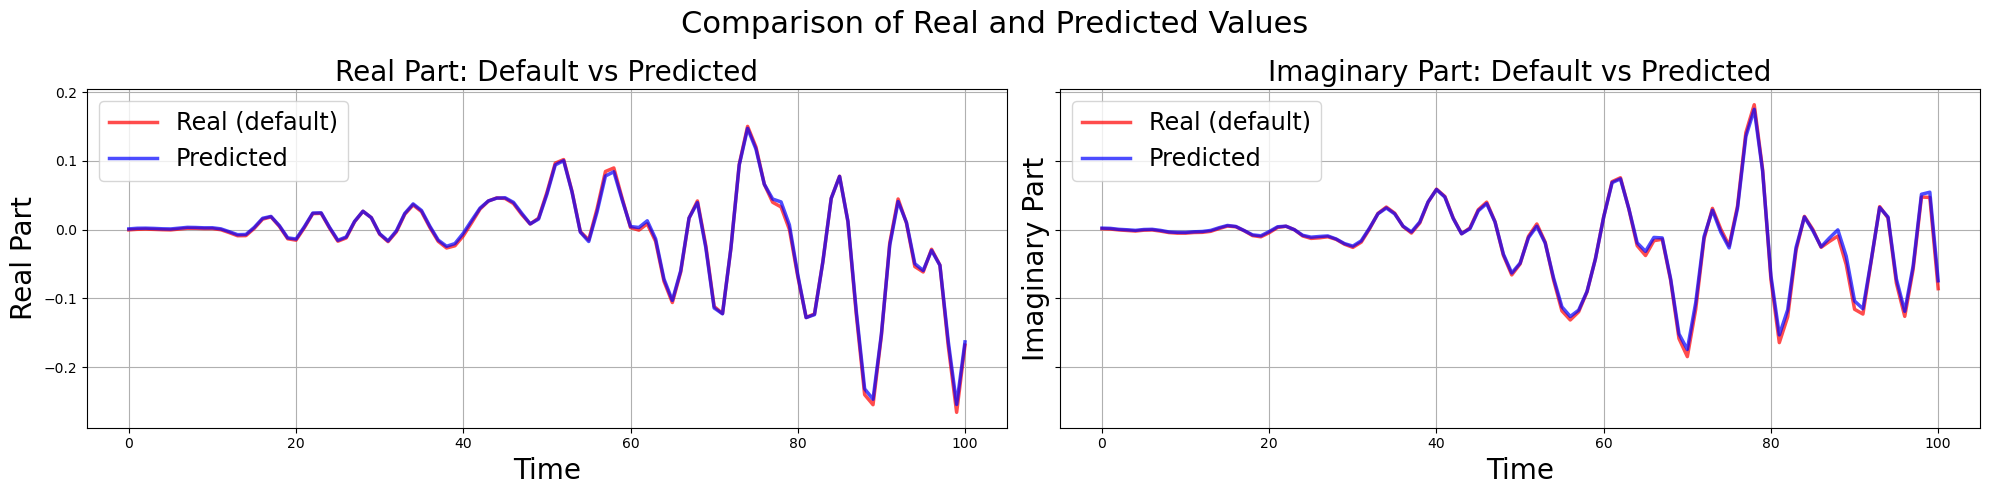

In [56]:
plot_predictions_vs_real(info_result, time_start=0, time_end=1.005e2)

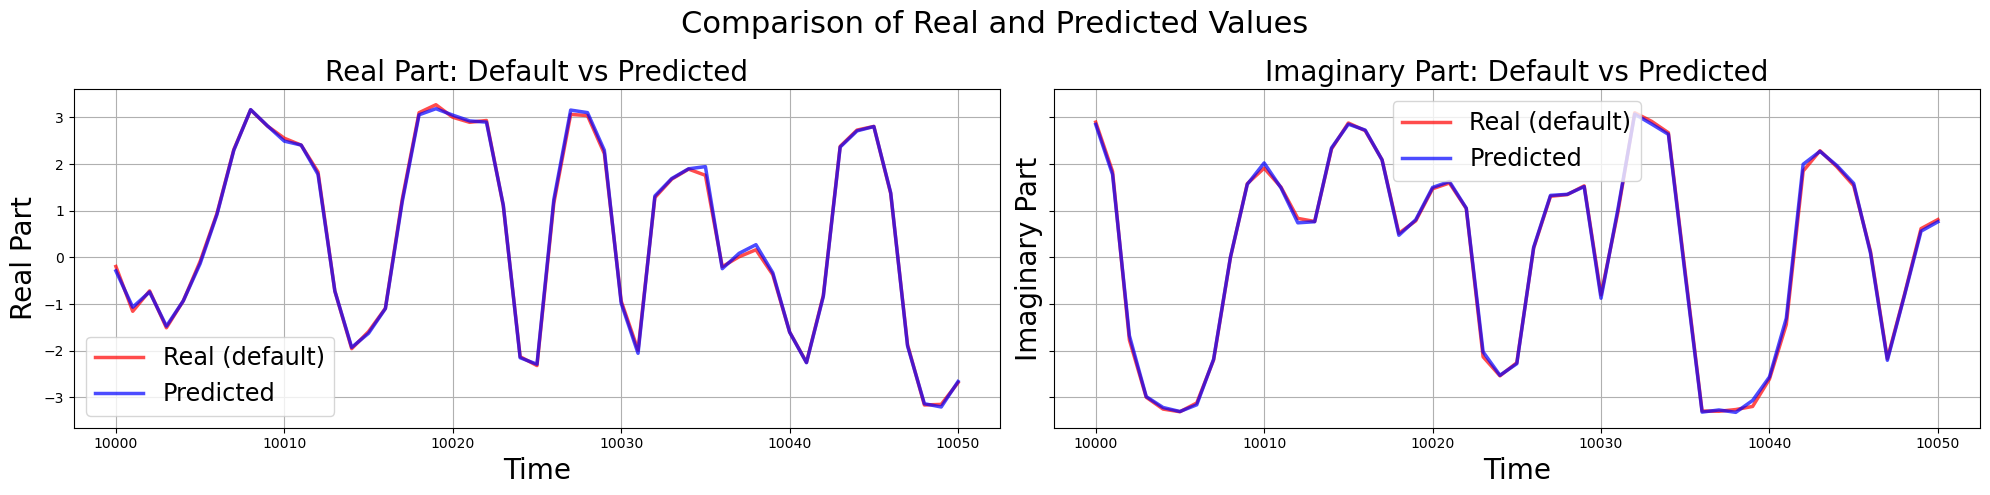

In [57]:
plot_predictions_vs_real(info_result, time_start=1e4, time_end=1.005e4)

In [58]:
# Удаляем ненужные тензоры
del X_train_tensor, Y_train_tensor, outputs, loss

# Вызываем сборщик мусора
gc.collect()

# Очищаем кэш памяти CUDA
torch.cuda.empty_cache()

### Real Valued Time delay Recurrent Neural Network (RVTDRNN)

In [30]:
# Функция для создания временных окон с задержками для входа и выхода
def create_time_delays_with_feedback(X_real, X_imag, Y_real, Y_imag, p, q):
    X_delayed = []
    Y_delayed = []
    
    for i in range(max(p, q), len(X_real)):
        # Входные задержки для X_real и X_imag
        X_real_window = X_real.iloc[i-p:i+1].values  # Входные задержки (x(k), x(k-1), ..., x(k-p))
        X_imag_window = X_imag.iloc[i-p:i+1].values
        
        # Обратная связь для Y_real и Y_imag
        Y_real_window = Y_real.iloc[i-q:i].values  # Обратная связь (y(k-1), y(k-2), ..., y(k-q))
        Y_imag_window = Y_imag.iloc[i-q:i].values
        
        # Комбинируем вещественные и мнимые части
        X_combined = np.concatenate([X_real_window, X_imag_window, Y_real_window, Y_imag_window])
        
        X_delayed.append(X_combined)
        
        # Текущие значения выходных данных
        Y_combined = np.array([Y_real.iloc[i], Y_imag.iloc[i]])
        Y_delayed.append(Y_combined)
    
    return np.array(X_delayed), np.array(Y_delayed)

In [31]:
# Параметры задержек (p и q)
p = 5  # Входная задержка
q = 5   # Выходная задержка

In [32]:
%%time

# Создание временных последовательностей с задержками и обратной связью
X_seq, Y_seq = create_time_delays_with_feedback(
    df['input_real'], 
    df['input_imag'], 
    df['output_real'], 
    df['output_imag'], 
    p, q
)

In [33]:
# Нормализация данных
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_seq)
Y_scaled = scaler_Y.fit_transform(Y_seq)

In [34]:
# Преобразование данных в тензоры PyTorch с добавлением временного измерения
X_train_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1).to(device)  # Добавляем временное измерение и переносим на device
Y_train_tensor = torch.tensor(Y_scaled, dtype=torch.float32).to(device)

In [35]:
# Создание DataLoader для мини-батчей
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [36]:
# Параметры модели
input_size = 2 * (p + 1 + q) - b * y - 1 # Входные и выходные задержки (вещественная и мнимая части)
hidden_size = 100  # Количество нейронов в скрытом слое
output_size = 2  # Вещественная и мнимая часть выходного сигнала
num_layers = 2  # Количество слоев в RNN
num_epochs = 100  # Количество эпох
learning_rate = 0.001  # Скорость обучения

In [40]:
class RVTDRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, p, q):
        super(RVTDRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Рекуррентный слой
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Полносвязный слой для преобразования выхода RNN
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Инициализация скрытых состояний
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Проход через RNN
        out, _ = self.rnn(x, h0)
        
        # Проход через полносвязный слой для предсказания
        out = self.fc(out[:, -1, :])
        return out

In [41]:
# Инициализация модели, функции потерь и оптимизатора
model = RVTDRNN(input_size, hidden_size, output_size, num_layers, p, q).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
%%time
# Список для хранения значений функции потерь
loss_values = []

# Задержка для измерения времени
start_time = time.time()

# Обучение модели
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, Y_batch in train_loader:
        # Перенос батчей на GPU
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  
        
        # Прямой проход
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        
        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * X_batch.size(0)  # Умножаем на размер батча для подсчета средней потери

    # Сохраняем среднее значение функции потерь для текущей эпохи
    avg_loss = epoch_loss / len(train_loader.dataset)
    loss_values.append(avg_loss)

    # if (epoch+1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

end_time = time.time()
elapsed = end_time - start_time
print(f"Обучение завершено за {elapsed:.2f} секунд.")

Epoch [1/100], Loss: 0.001234
Epoch [2/100], Loss: 0.001077
Epoch [3/100], Loss: 0.000955
Epoch [4/100], Loss: 0.000867
Epoch [5/100], Loss: 0.000780
Epoch [6/100], Loss: 0.000720
Epoch [7/100], Loss: 0.000658
Epoch [8/100], Loss: 0.000602
Epoch [9/100], Loss: 0.000551
Epoch [10/100], Loss: 0.000498
Epoch [11/100], Loss: 0.000457
Epoch [12/100], Loss: 0.000404
Epoch [13/100], Loss: 0.000373
Epoch [14/100], Loss: 0.000347
Epoch [15/100], Loss: 0.000316
Epoch [16/100], Loss: 0.000294
Epoch [17/100], Loss: 0.000278
Epoch [18/100], Loss: 0.000260
Epoch [19/100], Loss: 0.000244
Epoch [20/100], Loss: 0.000225
Epoch [21/100], Loss: 0.000217
Epoch [22/100], Loss: 0.000204
Epoch [23/100], Loss: 0.000193
Epoch [24/100], Loss: 0.000183
Epoch [25/100], Loss: 0.000175
Epoch [26/100], Loss: 0.000163
Epoch [27/100], Loss: 0.000159
Epoch [28/100], Loss: 0.000150
Epoch [29/100], Loss: 0.000150
Epoch [30/100], Loss: 0.000142
Epoch [31/100], Loss: 0.000140
Epoch [32/100], Loss: 0.000134
Epoch [33/100], L

In [29]:
class RVTDRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, p, q):
        super(RVTDRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.p = p
        self.q = q

        self.input_layer = nn.Linear(2*(p+1+q), hidden_size)
        self.hidden_layer1 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x, prev_outputs):
        batch_size = x.shape[0]
        x_reshaped = x.transpose(1, 2).contiguous().view(batch_size, -1)
        prev_outputs_reshaped = prev_outputs.transpose(1, 2).contiguous().view(batch_size, -1)
        combined_input = torch.cat((x_reshaped, prev_outputs_reshaped), dim=1)
        
        h1 = self.relu(self.input_layer(combined_input))
        h2 = self.relu(self.hidden_layer1(h1))
        h3 = self.relu(self.hidden_layer2(h2))
        output = self.tanh(self.output_layer(h3))
        
        return output.view(batch_size, 2, 1)

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.output_size, self.q)

In [30]:
class RVTDRNNDataset(Dataset):
    def __init__(self, data, p, q):
        self.data = data
        self.p = p
        self.q = q

    def __len__(self):
        return len(self.data) - max(self.p, self.q)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.p+1, :2].T
        y = self.data[idx+self.p, 2:].reshape(2, 1)
        prev_y = self.data[idx+self.p-self.q:idx+self.p, 2:].T
        return torch.FloatTensor(x), torch.FloatTensor(y), torch.FloatTensor(prev_y)

In [31]:
def preprocess_data(df, p, q):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    return data_scaled, scaler

In [32]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for x, y, prev_y in train_loader:
            x, y, prev_y = x.to(device), y.to(device), prev_y.to(device)
            optimizer.zero_grad()
            output = model(x, prev_y)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y, prev_y in val_loader:
                x, y, prev_y = x.to(device), y.to(device), prev_y.to(device)
                output = model(x, prev_y)
                loss = criterion(output, y)
                val_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

In [33]:
def predict(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x, _, prev_y in test_loader:
            x, prev_y = x.to(device), prev_y.to(device)
            output = model(x, prev_y)
            predictions.append(output.cpu().numpy())
    return np.concatenate(predictions)

In [34]:
# Параметры задержек (p и q)
p = 5  # Входная задержка
q = 5   # Выходная задержка
hidden_size = 64
batch_size = 32
num_epochs = 50
learning_rate = 0.001

In [35]:
data_scaled, scaler = preprocess_data(df, p, q)

In [36]:
train_data, val_data = train_test_split(data_scaled, test_size=0.2, random_state=123456)

In [37]:
train_dataset = RVTDRNNDataset(train_data, p, q)
val_dataset = RVTDRNNDataset(val_data, p, q)

In [38]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [39]:
# Инициализация модели, обучение и визуализация
model = RVTDRNN(input_size=2, hidden_size=hidden_size, output_size=2, p=p, q=q).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/50, Train Loss: 0.0858, Val Loss: 0.0686
Epoch 2/50, Train Loss: 0.0667, Val Loss: 0.0657
Epoch 3/50, Train Loss: 0.0658, Val Loss: 0.0659
Epoch 4/50, Train Loss: 0.0655, Val Loss: 0.0649
Epoch 5/50, Train Loss: 0.0654, Val Loss: 0.0650
Epoch 6/50, Train Loss: 0.0652, Val Loss: 0.0648
Epoch 7/50, Train Loss: 0.0651, Val Loss: 0.0647
Epoch 8/50, Train Loss: 0.0650, Val Loss: 0.0650
Epoch 9/50, Train Loss: 0.0649, Val Loss: 0.0652
Epoch 10/50, Train Loss: 0.0648, Val Loss: 0.0647
Epoch 11/50, Train Loss: 0.0648, Val Loss: 0.0644
Epoch 12/50, Train Loss: 0.0647, Val Loss: 0.0646
Epoch 13/50, Train Loss: 0.0647, Val Loss: 0.0645
Epoch 14/50, Train Loss: 0.0647, Val Loss: 0.0644
Epoch 15/50, Train Loss: 0.0647, Val Loss: 0.0646
Epoch 16/50, Train Loss: 0.0646, Val Loss: 0.0644
Epoch 17/50, Train Loss: 0.0646, Val Loss: 0.0644
Epoch 18/50, Train Loss: 0.0646, Val Loss: 0.0645
Epoch 19/50, Train Loss: 0.0646, Val Loss: 0.0645
Epoch 20/50, Train Loss: 0.0646, Val Loss: 0.0644
Epoch 21/

In [ ]:
predictions = predict(model, test_loader, device)
predictions_original = scaler.inverse_transform(predictions.reshape(-1, 2))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(test_data[:len(predictions), 2], predictions_original[:, 0], alpha=0.5)
plt.xlabel('True Output (Real)')
plt.ylabel('Predicted Output (Real)')
plt.title('Real Component: True vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(test_data[:len(predictions), 3], predictions_original[:, 1], alpha=0.5)
plt.xlabel('True Output (Imaginary)')
plt.ylabel('Predicted Output (Imaginary)')
plt.title('Imaginary Component: True vs Predicted')

plt.tight_layout()
plt.show()

In [ ]:
# Make predictions
predictions = predict(model, test_loader, device)

# Inverse transform predictions
predictions_original = scaler.inverse_transform(predictions.reshape(-1, 2))

### Real Valued Focused Time Delay Neural Network (RVFTDNN)

### Real Valued Recurrent Neural Network (RVRNN)

## Результаты

In [59]:
results = pd.DataFrame(results).T

In [60]:
# Смотрим на результаты
display(results)

NAME RMSE TRAIN RMSE VALID REAL RMSE VALID IMAG TIME TRAINING [s]  \
0  CTDRNN       None        0.010986        0.010004        734.214262   
1   CTDNN       None         0.05453        0.054318         67.666911   

  TIME PREDICTION [s]                                        PREDICTIONS  \
0                None  [[0.008708529, 0.0060001696], [0.009501646, 0....   
1                None  [[0.0010361865, 0.002167537], [0.0019709175, 0...   

                                           PARAMETRS  
0  {'lstm.weight_ih_l0': [[tensor(-0.0367, device...  
1  {'fc1.weight': [[tensor(0.1038, device='cuda:0...

In [61]:
# Рассчитываем рейтинг с учетом указанных приоритетов
results['RATING'] = (
    0.45 * (1 - (results['RMSE VALID REAL'] / results['RMSE VALID REAL'].max())) +
    0.45 * (1 - (results['RMSE VALID IMAG'] / results['RMSE VALID IMAG'].max())) +
    0.1 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max()))
)

# Сортируем DataFrame по убыванию рейтинга
results = results.sort_values(by='RATING', ascending=False)

In [62]:
# Смотрим на результаты
display(results)

NAME RMSE TRAIN RMSE VALID REAL RMSE VALID IMAG TIME TRAINING [s]  \
0  CTDRNN       None        0.010986        0.010004        734.214262   
1   CTDNN       None         0.05453        0.054318         67.666911   

  TIME PREDICTION [s]                                        PREDICTIONS  \
0                None  [[0.008708529, 0.0060001696], [0.009501646, 0....   
1                None  [[0.0010361865, 0.002167537], [0.0019709175, 0...   

                                           PARAMETRS    RATING  
0  {'lstm.weight_ih_l0': [[tensor(-0.0367, device...  0.726467  
1  {'fc1.weight': [[tensor(0.1038, device='cuda:0...  0.090784

# Машинное обучение

In [63]:
# Здесь будем сохранить результаты обучения
results = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

In [64]:
# Определение входных и выходных данных
features = df[['input_real', 'input_imag']]
targets = df[['output_real', 'output_imag']]

## Деление на обучающей и валидационной выборки

**Обучение моделей с применением TimeSeriesSplit**

Почему обучаем с применением TimeSeriesSplit, потому что мы обучаем модель, у которой по индексу стоит временный ряд. А чтобы они не пересекались, это поможет инструмент TimeSeriesSplit.

In [65]:
# Не будем создавать по-умолчанию, где n_splits=5, а установим n_splits=10
tscv = TimeSeriesSplit(10)
display(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)

In [66]:
# Разделение на обучающую и валидационную выборки
features_train, features_valid, targets_train, targets_valid = train_test_split(features, targets, test_size=0.2, random_state=123456)

## Обучение модели

### LinearRegression

In [67]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), LinearRegression())
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={}, scoring='neg_root_mean_squared_error')

In [68]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.8658672581599522
TIME TRAIN [s]: 0.02


**Проверка на валидационной выборки**

In [69]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.7488804442530592
RMSE для мнимой части: 0.7531629903468988
CPU times: user 33.5 ms, sys: 5.03 ms, total: 38.5 ms
Wall time: 4.75 ms


In [70]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                    LinearRegression
RMSE TRAIN                                                      0.865867
RMSE VALID REAL                                                  0.74888
RMSE VALID IMAG                                                 0.753163
TIME TRAINING [s]                                               0.020961
TIME PREDICTION [s]                                                0.003
PREDICTIONS            [[-0.28832698573917814, 1.936889405288186], [-...
PARAMETRS                                                             {}
Name: 0, dtype: object

### KNeighborsRegressor

In [71]:
# Задаем значения гиперпараметров
parameters = {
    # Пример значений, можно добавить свои
    'kneighborsregressor__n_neighbors': [1, 2],  
    # 'weights': ['uniform', 'distance'],
    'kneighborsregressor__weights': ['uniform'],
    # для параметра метрики (1 - манхэттенское расстояние, 2 - евклидово расстояние)
    # 'kneighborsregressor__p': [1]  
}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), KNeighborsRegressor())
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': [1, 2],
                         'kneighborsregressor__weights': ['uniform']},
             scoring='neg_root_mean_squared_error')

In [72]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.3862943803573481
TIME TRAIN [s]: 0.06


**Проверка на валидационной выборки**

In [73]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.14756557815883273
RMSE для мнимой части: 0.1483683860179619
CPU times: user 102 ms, sys: 2.02 ms, total: 104 ms
Wall time: 103 ms


In [74]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                 KNeighborsRegressor
RMSE TRAIN                                                      0.386294
RMSE VALID REAL                                                 0.147566
RMSE VALID IMAG                                                 0.148368
TIME TRAINING [s]                                               0.061688
TIME PREDICTION [s]                                                0.102
PREDICTIONS            [[-0.44020349999999997, 2.974165], [-2.74305, ...
PARAMETRS              {'kneighborsregressor__n_neighbors': 2, 'kneig...
Name: 1, dtype: object

### DecisionTreeRegressor

In [75]:
parameters = {
    'decisiontreeregressor__max_depth': range(1, 101, 10),
    'decisiontreeregressor__min_samples_leaf': [1, 0.5]
}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=12345))
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=12345))]),
             param_grid={'decisiontreeregressor__max_depth': range(1, 101, 10),
                         'decisiontreeregressor__min_samples_leaf': [1, 0.5]},
             scoring='neg_root_mean_squared_error')

In [76]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.37621486671960813
TIME TRAIN [s]: 0.3


**Проверка на валидационной выборки**

In [77]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.13459805580403986
RMSE для мнимой части: 0.1339878847137597
CPU times: user 4.8 ms, sys: 2.98 ms, total: 7.77 ms
Wall time: 6.32 ms


In [78]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                               DecisionTreeRegressor
RMSE TRAIN                                                      0.376215
RMSE VALID REAL                                                 0.134598
RMSE VALID IMAG                                                 0.133988
TIME TRAINING [s]                                               0.296888
TIME PREDICTION [s]                                                0.005
PREDICTIONS            [[-0.5637410662983423, 2.8974165193370167], [-...
PARAMETRS              {'decisiontreeregressor__max_depth': 11, 'deci...
Name: 2, dtype: object

### LightGBMRegressor

In [79]:
# Матрица гиперпараметров для LGBMRegressor
parameters = {
    'multioutputregressor__estimator__n_estimators': [10, 25],
    'multioutputregressor__estimator__learning_rate': [0.1, 0.3],
    'multioutputregressor__estimator__max_depth': [5, 15],
    'multioutputregressor__estimator__num_leaves': [5, 10],
}

# Оборачиваем LGBMR в MultiOutputRegressor
multi_target_lgbmr = MultiOutputRegressor(LGBMRegressor())

# Инициализируем модель с параметрами и создаем конвейер
pipeline_scale = make_pipeline(StandardScaler(), multi_target_lgbmr)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=LGBMRegressor()))]),
             param_grid={'multioutputregressor__estimator__learning_rate': [0.1,
                                                                            0.3],
                         'multioutputregressor__estimator__max_depth': [5, 15],
                         'multioutputregressor__estimator__n_estimators': [10,
                                                                           25],
                         'multioutputregressor__estimator__num_leaves': [5,
                                                                         10]},
             scoring='neg_root_mean_squared_error')

In [80]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12515, number of used features: 2
[LightGBM] [Info] Start training from score 0.003815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12515, number of used features: 2
[LightGBM] [Info] Start training from score 0.015188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 25026, number of used features: 2
[LightGBM] [Info] Start training 

**Проверка на валидационной выборки**

In [81]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.1713299102926755
RMSE для мнимой части: 0.1723867719656781
CPU times: user 132 ms, sys: 9.17 ms, total: 141 ms
Wall time: 17.6 ms


In [82]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                MultiOutputRegressor
RMSE TRAIN                                                      0.416362
RMSE VALID REAL                                                  0.17133
RMSE VALID IMAG                                                 0.172387
TIME TRAINING [s]                                               0.126176
TIME PREDICTION [s]                                                0.016
PREDICTIONS            [[-0.33606733176649484, 3.0045329003957586], [...
PARAMETRS              {'multioutputregressor__estimator__learning_ra...
Name: 3, dtype: object

### CatBoostRegressor

In [83]:
# Матрица гиперпараметров для CatBoostRegressor
parameters = {
    'multioutputregressor__estimator__iterations': [5, 10],
    'multioutputregressor__estimator__learning_rate': [0.1, 0.5],
    'multioutputregressor__estimator__depth': [5, 15],
}

# Оборачиваем CatBoostRegressor в MultiOutputRegressor
multi_target_cbr = MultiOutputRegressor(CatBoostRegressor())

# Инициализируем модель с параметрами и создаем конвейер
pipeline_scale = make_pipeline(StandardScaler(), multi_target_cbr)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x78989bd3fc10>))]),
             param_grid={'multioutputregressor__estimator__depth': [5, 15],
                         'multioutputregressor__estimator__iterations': [5, 10],
                         'multioutputregressor__estimator__learning_rate': [0.1,
                                                                            0.5]},
             scoring='neg_root_mean_squared_error')

In [84]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

0:	learn: 1.9013737	total: 48.4ms	remaining: 193ms
1:	learn: 1.7306095	total: 50.2ms	remaining: 75.3ms
2:	learn: 1.5795488	total: 52.6ms	remaining: 35.1ms
3:	learn: 1.4394106	total: 54.5ms	remaining: 13.6ms
4:	learn: 1.3128407	total: 56.2ms	remaining: 0us
0:	learn: 1.9010003	total: 5.93ms	remaining: 23.7ms
1:	learn: 1.7313272	total: 8.95ms	remaining: 13.4ms
2:	learn: 1.5814113	total: 11.8ms	remaining: 7.85ms
3:	learn: 1.4447014	total: 15.1ms	remaining: 3.78ms
4:	learn: 1.3188330	total: 18.6ms	remaining: 0us
0:	learn: 1.9039942	total: 2.17ms	remaining: 8.69ms
1:	learn: 1.7343293	total: 4ms	remaining: 6ms
2:	learn: 1.5823872	total: 5.87ms	remaining: 3.91ms
3:	learn: 1.4419239	total: 7.95ms	remaining: 1.99ms
4:	learn: 1.3152449	total: 10ms	remaining: 0us
0:	learn: 1.9005997	total: 1.68ms	remaining: 6.72ms
1:	learn: 1.7316318	total: 3.11ms	remaining: 4.67ms
2:	learn: 1.5763051	total: 4.64ms	remaining: 3.09ms
3:	learn: 1.4377097	total: 6.38ms	remaining: 1.59ms
4:	learn: 1.3136369	total: 8.5

**Проверка на валидационной выборки**

In [85]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.14433298570142392
RMSE для мнимой части: 0.1442852424131891
CPU times: user 18.5 ms, sys: 5.55 ms, total: 24 ms
Wall time: 6.42 ms


In [86]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                MultiOutputRegressor
RMSE TRAIN                                                       0.38449
RMSE VALID REAL                                                 0.144333
RMSE VALID IMAG                                                 0.144285
TIME TRAINING [s]                                               5.530213
TIME PREDICTION [s]                                                0.006
PREDICTIONS            [[-0.5793409857007769, 3.00895793161571], [-2....
PARAMETRS              {'multioutputregressor__estimator__depth': 15,...
Name: 4, dtype: object

### BaggingRegressor

In [87]:
# Матрица гиперпараметров для BaggingRegressor
parameters = {
    'baggingregressor__n_estimators': [10, 25],
    'baggingregressor__random_state': [12345] 
}

# Инициализируем модель с параметрами и создаем конвейер
# Инициализируем BaggingRegressor отдельно
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10), random_state=12345)
pipeline_scale = make_pipeline(StandardScaler(), bagging_model)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('baggingregressor',
                                        BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                                                         random_state=12345))]),
             param_grid={'baggingregressor__n_estimators': [10, 25],
                         'baggingregressor__random_state': [12345]},
             scoring='neg_root_mean_squared_error')

In [88]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.35696216171103107
TIME TRAIN [s]: 4.5


**Проверка на валидационной выборки**

In [89]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.12555557093909708
RMSE для мнимой части: 0.1261163382483048
CPU times: user 74.8 ms, sys: 953 µs, total: 75.8 ms
Wall time: 74.7 ms


In [90]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                    BaggingRegressor
RMSE TRAIN                                                      0.356962
RMSE VALID REAL                                                 0.125556
RMSE VALID IMAG                                                 0.126116
TIME TRAINING [s]                                               4.503093
TIME PREDICTION [s]                                                0.073
PREDICTIONS            [[-0.5211061075152857, 3.000718101419898], [-2...
PARAMETRS              {'baggingregressor__n_estimators': 25, 'baggin...
Name: 5, dtype: object

## Результаты

In [91]:
results = pd.DataFrame(results).T

In [92]:
# Смотрим на результаты
display(results)

NAME RMSE TRAIN RMSE VALID REAL RMSE VALID IMAG  \
0       LinearRegression   0.865867         0.74888        0.753163   
1    KNeighborsRegressor   0.386294        0.147566        0.148368   
2  DecisionTreeRegressor   0.376215        0.134598        0.133988   
3   MultiOutputRegressor   0.416362         0.17133        0.172387   
4   MultiOutputRegressor    0.38449        0.144333        0.144285   
5       BaggingRegressor   0.356962        0.125556        0.126116   

  TIME TRAINING [s] TIME PREDICTION [s]  \
0          0.020961               0.003   
1          0.061688               0.102   
2          0.296888               0.005   
3          0.126176               0.016   
4          5.530213               0.006   
5          4.503093               0.073   

                                         PREDICTIONS  \
0  [[-0.28832698573917814, 1.936889405288186], [-...   
1  [[-0.44020349999999997, 2.974165], [-2.74305, ...   
2  [[-0.5637410662983423, 2.8974165193370167], [-...   
3  [[-0.33606733176649484, 3.0045329003957586], [...   
4  [[-0.5793409857007769, 3.00895793161571], [-2....   
5  [[-0.5211061075152857, 3.000718101419898], [-2...   

                                           PARAMETRS  
0                                                 {}  
1  {'kneighborsregressor__n_neighbors': 2, 'kneig...  
2  {'decisiontreeregressor__max_depth': 11, 'deci...  
3  {'multioutputregressor__estimator__learning_ra...  
4  {'multioutputregressor__estimator__depth': 15,...  
5  {'baggingregressor__n_estimators': 25, 'baggin...

In [93]:
# Рассчитываем рейтинг с учетом указанных приоритетов
results['RATING'] = (
    0.45 * (1 - (results['RMSE VALID REAL'] / results['RMSE VALID REAL'].max())) +
    0.45 * (1 - (results['RMSE VALID IMAG'] / results['RMSE VALID IMAG'].max())) +
    0.1 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max()))
    # 0.1 * (1 - (results['TIME PREDICTION [s]'] / results['TIME PREDICTION [s]'].max()))
)

# Сортируем DataFrame по убыванию рейтинга
results = results.sort_values(by='RATING', ascending=False)

In [94]:
# Смотрим на результаты
display(results)

NAME RMSE TRAIN RMSE VALID REAL RMSE VALID IMAG  \
2  DecisionTreeRegressor   0.376215        0.134598        0.133988   
1    KNeighborsRegressor   0.386294        0.147566        0.148368   
3   MultiOutputRegressor   0.416362         0.17133        0.172387   
5       BaggingRegressor   0.356962        0.125556        0.126116   
4   MultiOutputRegressor    0.38449        0.144333        0.144285   
0       LinearRegression   0.865867         0.74888        0.753163   

  TIME TRAINING [s] TIME PREDICTION [s]  \
2          0.296888               0.005   
1          0.061688               0.102   
3          0.126176               0.016   
5          4.503093               0.073   
4          5.530213               0.006   
0          0.020961               0.003   

                                         PREDICTIONS  \
2  [[-0.5637410662983423, 2.8974165193370167], [-...   
1  [[-0.44020349999999997, 2.974165], [-2.74305, ...   
3  [[-0.33606733176649484, 3.0045329003957586], [...   
5  [[-0.5211061075152857, 3.000718101419898], [-2...   
4  [[-0.5793409857007769, 3.00895793161571], [-2....   
0  [[-0.28832698573917814, 1.936889405288186], [-...   

                                           PARAMETRS    RATING  
2  {'decisiontreeregressor__max_depth': 11, 'deci...  0.833697  
1  {'kneighborsregressor__n_neighbors': 2, 'kneig...  0.821566  
3  {'multioutputregressor__estimator__learning_ra...  0.791769  
5  {'baggingregressor__n_estimators': 25, 'baggin...  0.767775  
4  {'multioutputregressor__estimator__depth': 15,...  0.727063  
0                                                 {}  0.099621

**Создадим отдельный датасет, в котором будет храниться реальное значение и предсказания модели**

In [95]:
# Используем индексы валидационных данных
info_result = pd.DataFrame(index=targets_valid.index)

info_result['default_real'] = targets_valid['output_real']
info_result['default_imag'] = targets_valid['output_imag']

for i, name_model in enumerate(results['NAME']):
    info_result[name_model+'_real'] = results['PREDICTIONS'][i][:, 0]  # Предсказанные значения действительной части
    info_result[name_model+'_imag'] = results['PREDICTIONS'][i][:, 1]  # Предсказанные значения действительной части

# Сортировка DataFrame по индексу
info_result = info_result.sort_index()

info_result.head()

default_real  default_imag  DecisionTreeRegressor_real  \
time                                                                   
6.500000e-08      0.000358     -0.001267                   -0.003513   
8.000000e-08      0.000814     -0.000496                   -0.003214   
9.000000e-08      0.001889     -0.004296                   -0.003431   
1.800000e-07     -0.012080     -0.011916                   -0.009650   
1.900000e-07      0.026646     -0.014216                    0.004099   

              DecisionTreeRegressor_imag  KNeighborsRegressor_real  \
time                                                                 
6.500000e-08                   -0.000698                  0.000346   
8.000000e-08                   -0.000472                  0.000398   
9.000000e-08                   -0.002047                  0.001465   
1.800000e-07                   -0.002516                 -0.015121   
1.900000e-07                   -0.009515                  0.063197   

              KNeighborsRegressor_imag  MultiOutputRegressor_real  \
time                                                                
6.500000e-08                 -0.001271                  -0.118049   
8.000000e-08                 -0.000223                  -0.118049   
9.000000e-08                 -0.005154                  -0.118049   
1.800000e-07                 -0.011610                  -0.118049   
1.900000e-07                 -0.011673                  -0.118049   

              MultiOutputRegressor_imag  BaggingRegressor_real  \
time                                                             
6.500000e-08                   0.028836               0.552150   
8.000000e-08                   0.028836               0.552150   
9.000000e-08                   0.028836               0.552150   
1.800000e-07                   0.028836              -0.343024   
1.900000e-07                   0.028836               0.552150   

              BaggingRegressor_imag  LinearRegression_real  \
time                                                         
6.500000e-08               0.427222              -0.017098   
8.000000e-08               0.427222              -0.017098   
9.000000e-08              -0.268951              -0.033412   
1.800000e-07               0.427222              -0.043926   
1.900000e-07              -0.268951              -0.012356   

              LinearRegression_imag  
time                                 
6.500000e-08              -0.007220  
8.000000e-08              -0.007220  
9.000000e-08              -0.024787  
1.800000e-07              -0.027412  
1.900000e-07              -0.010523

In [96]:
def plot_predictions_vs_real(info_result, time_start, time_end):
    # Определяем количество моделей, минус 1 для 'default_real' и 'default_imag'
    num_models = len(info_result.columns) // 2 - 1  

    for i in range(num_models):
        col_real = 'default_real'
        col_pred_real = info_result.columns[2 * i + 2]
        col_pred_imag = info_result.columns[2 * i + 3]

        # Фильтрация данных по временной отметке
        filtered_data = info_result[(info_result.index >= time_start) & (info_result.index <= time_end)]
        time = filtered_data.index

        # Создание фигуры с двумя подграфиками
        fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
        
        # Общий заголовок для всей фигуры
        fig.suptitle(f'Graph of default and predicted values ({col_pred_real.split("_")[0]})', fontsize=22)

        # Построение графиков реальных значений
        axs[0].plot(time, filtered_data[col_real], alpha=0.7, color='red', lw=2.5, label='default')
        axs[0].plot(time, filtered_data[col_pred_real], alpha=0.7, color='blue', lw=2.5, label='prediction')
        axs[0].legend(fontsize='xx-large')
        axs[0].grid()
        axs[0].set_xlabel('Time series', fontsize=20)
        axs[0].set_ylabel('Value', fontsize=20)
        axs[0].set_title('REAL', fontsize=20)

        # Построение графиков мнимых значений
        axs[1].plot(time, filtered_data['default_imag'], alpha=0.7, color='red', lw=2.5, label='default')
        axs[1].plot(time, filtered_data[col_pred_imag], alpha=0.7, color='blue', lw=2.5, label='prediction')
        axs[1].legend(fontsize='xx-large')
        axs[1].grid()
        axs[1].set_xlabel('Time series', fontsize=20)
        axs[1].set_ylabel('Value', fontsize=20)
        axs[1].set_title('IMAG', fontsize=20)

        # Показываем график
        plt.tight_layout()
        plt.show()

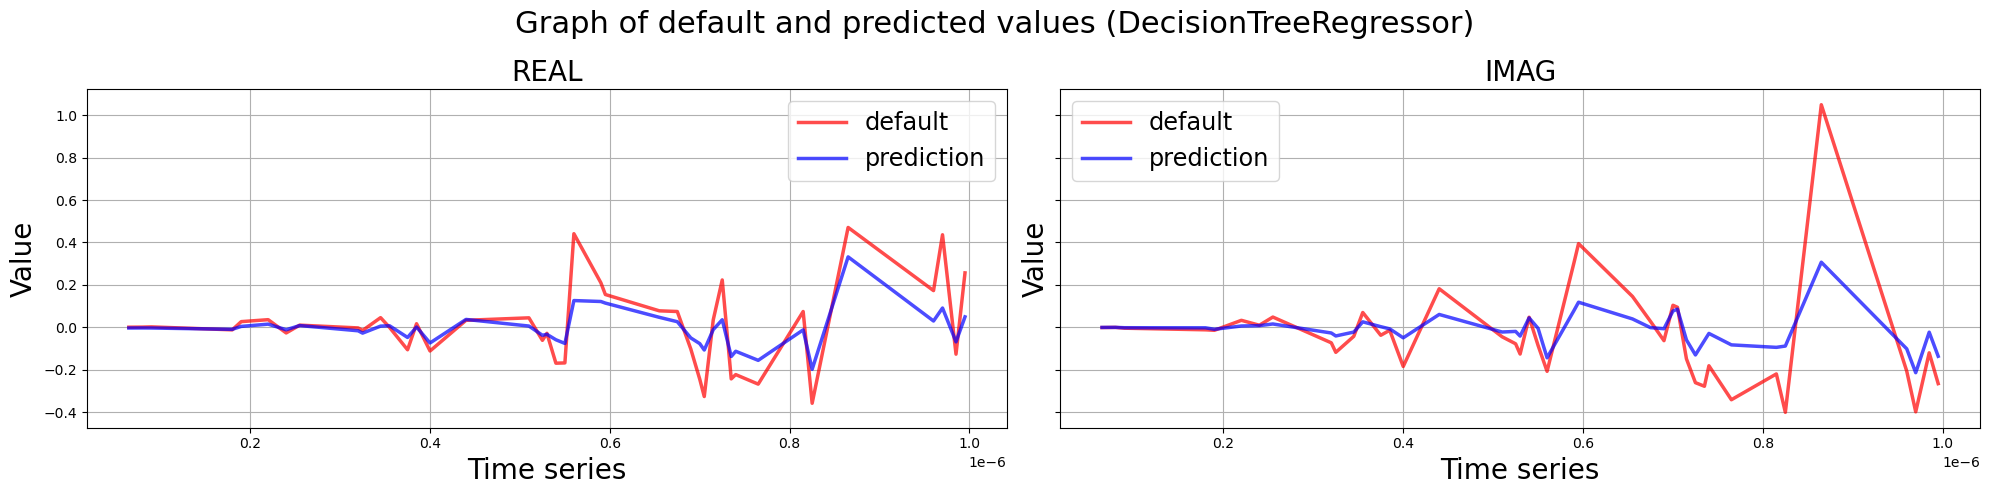

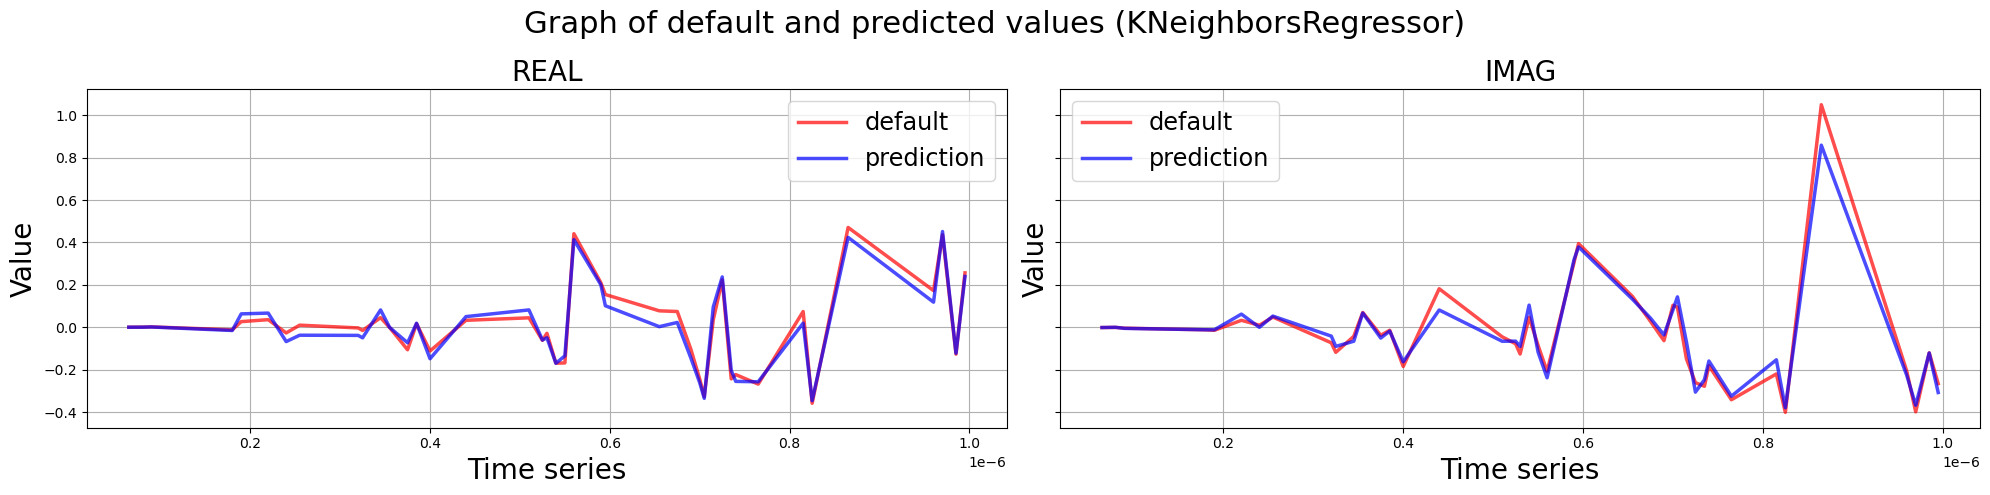

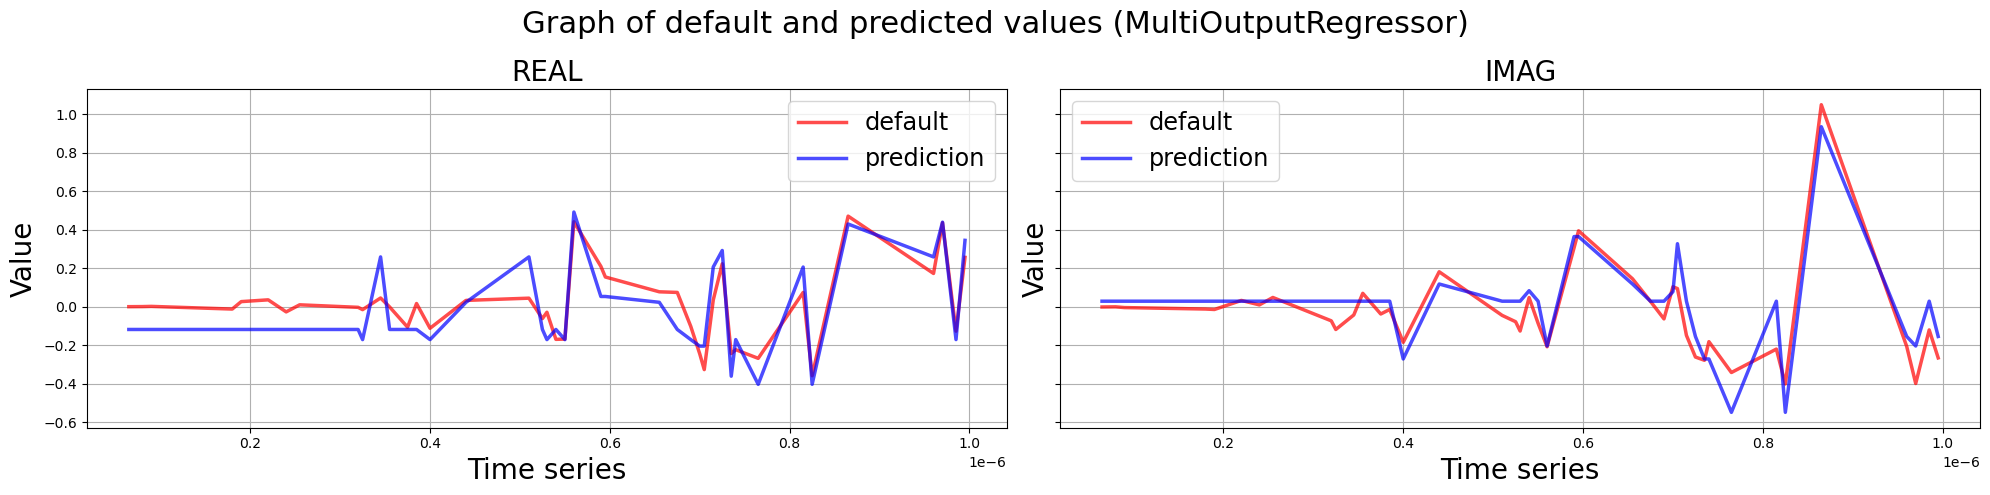

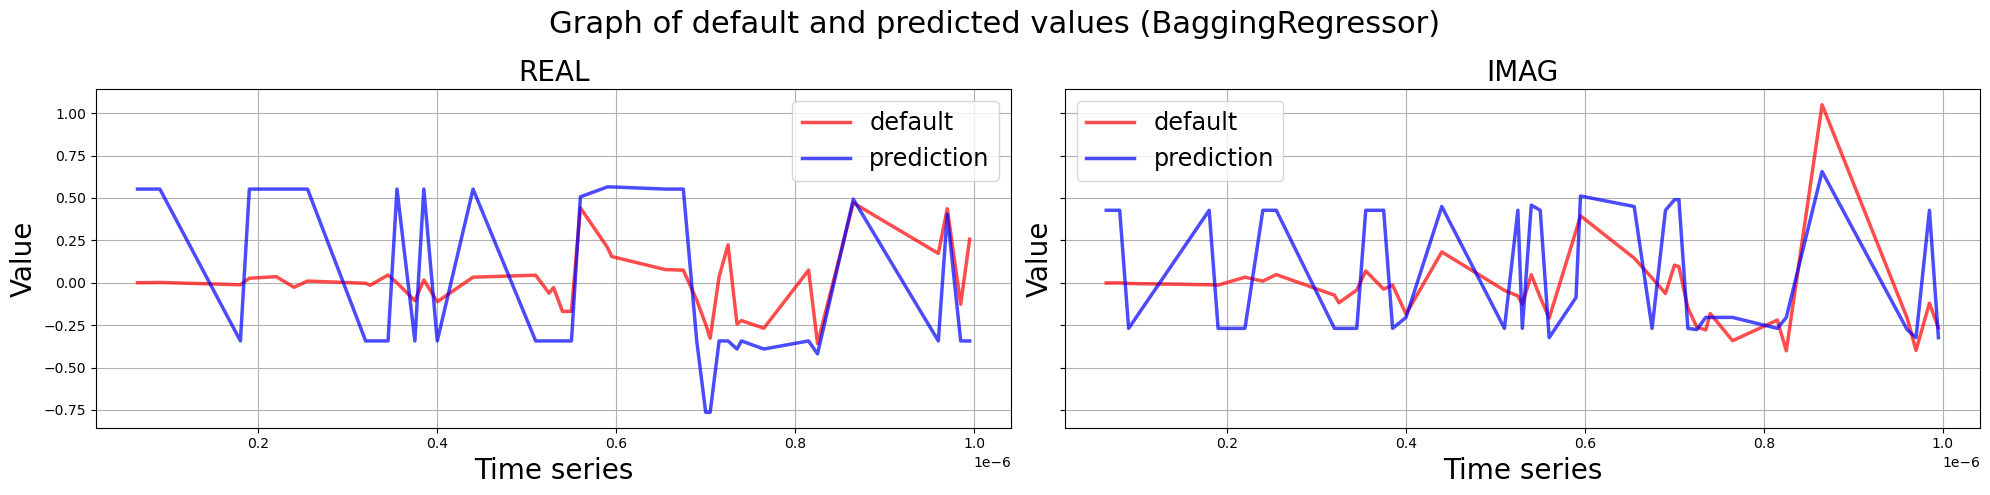

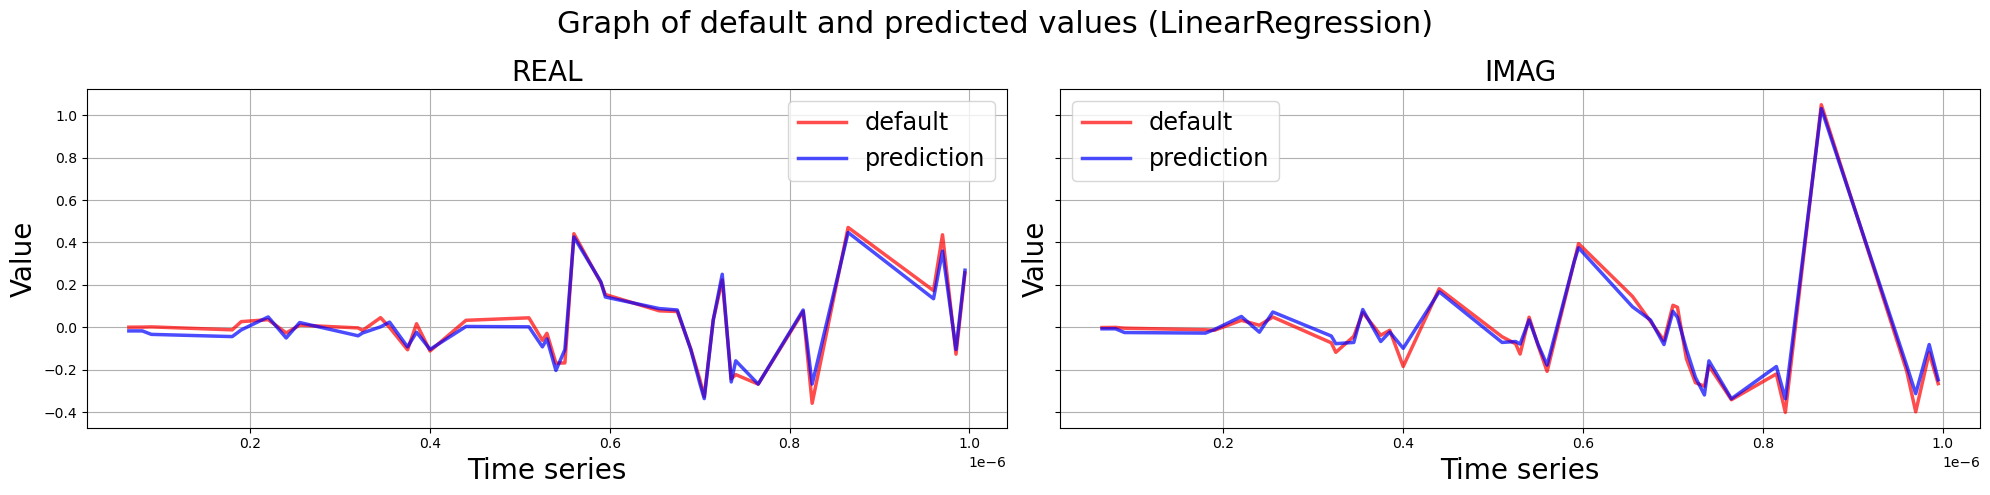

In [97]:
plot_predictions_vs_real(info_result, time_start=0, time_end=1e-6)

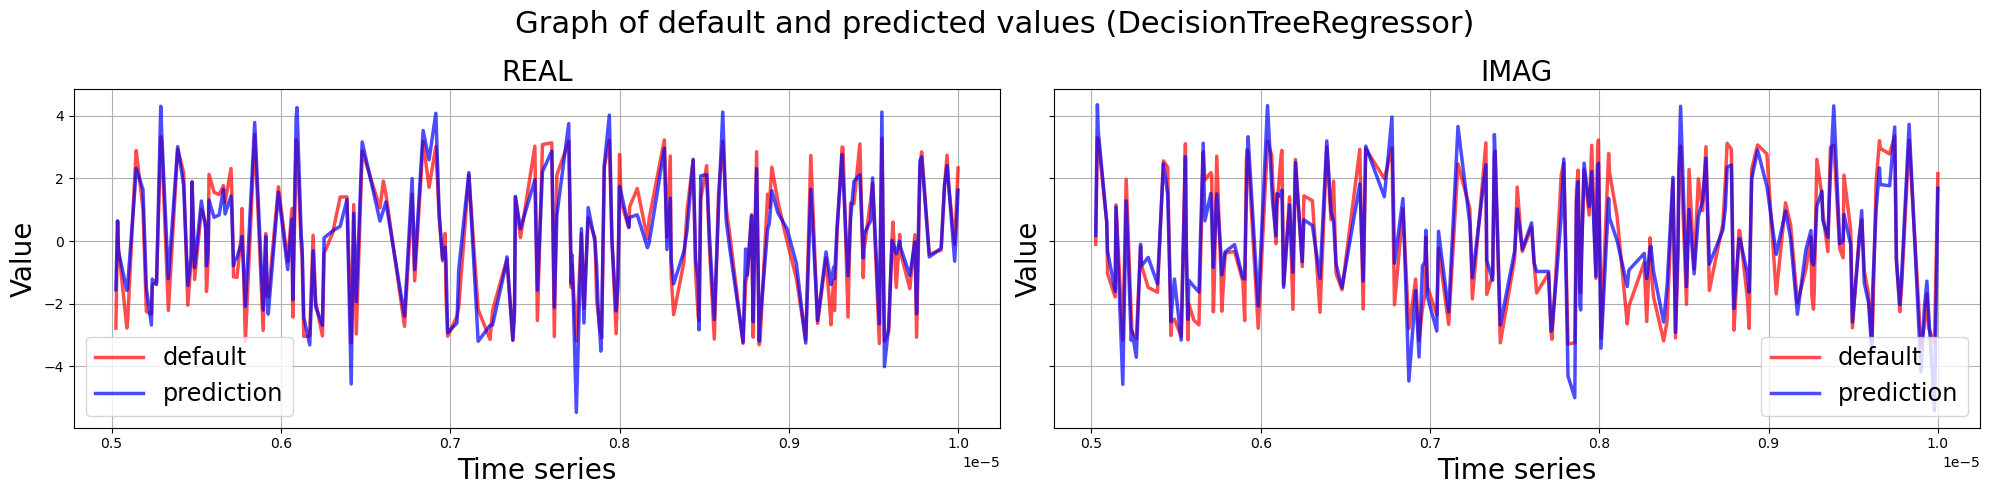

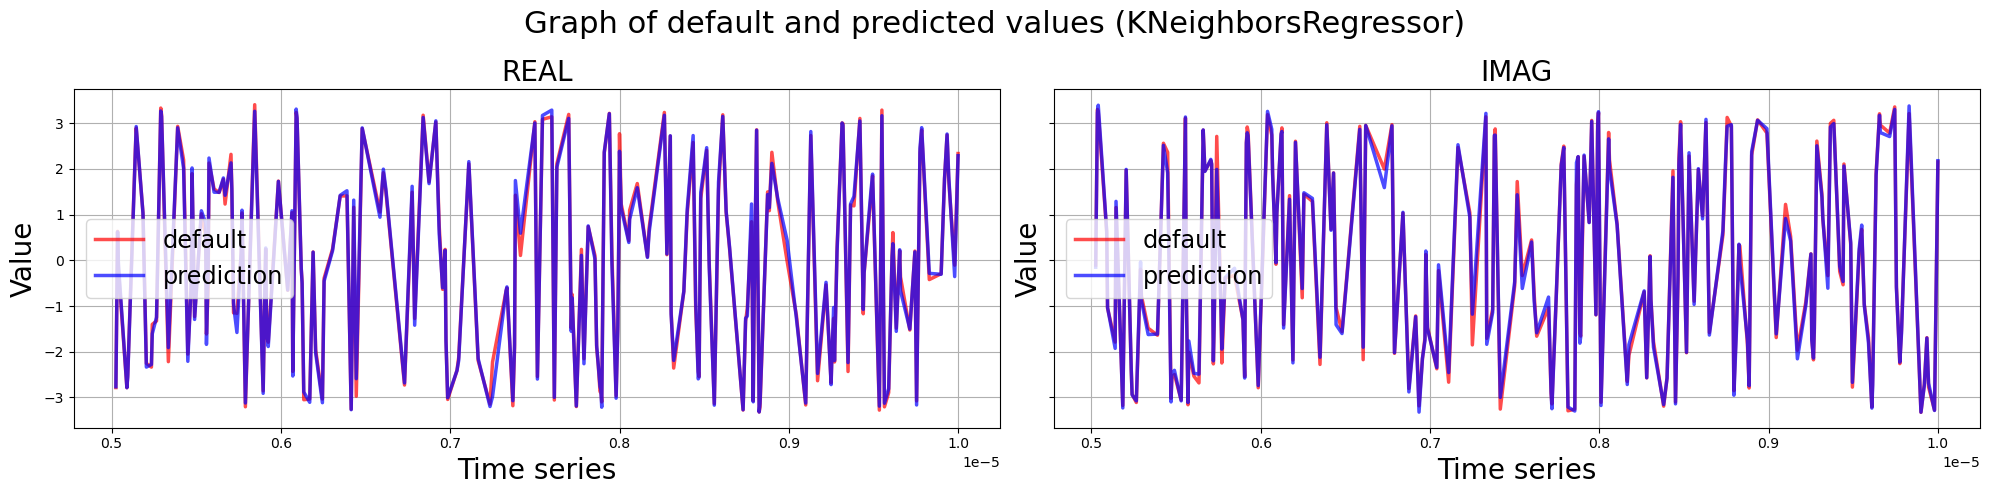

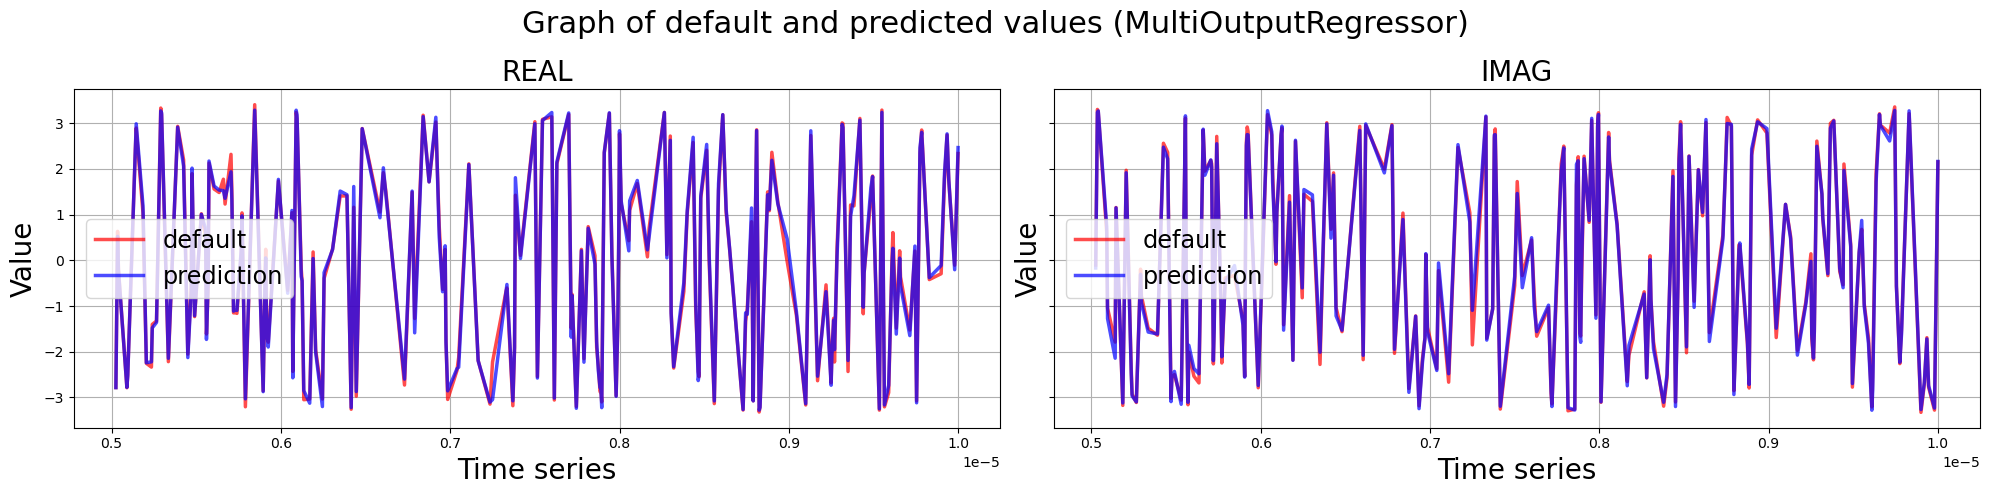

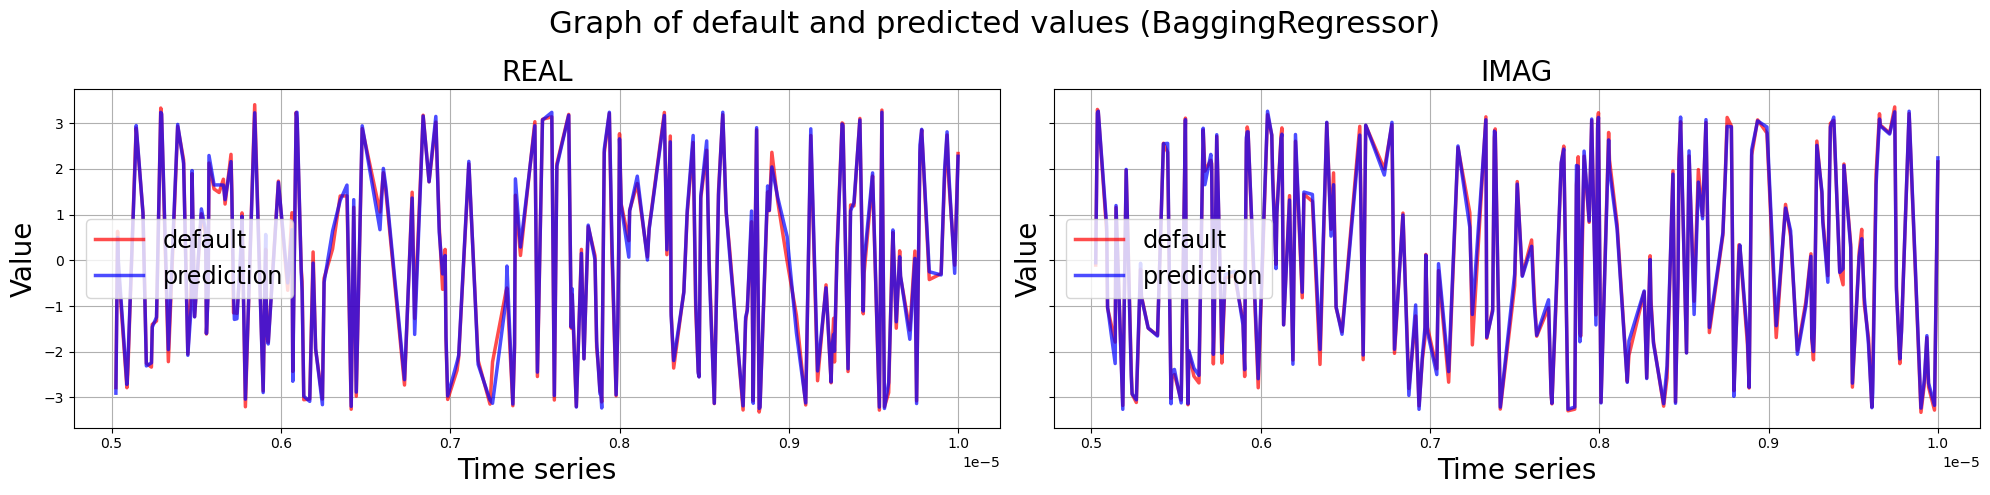

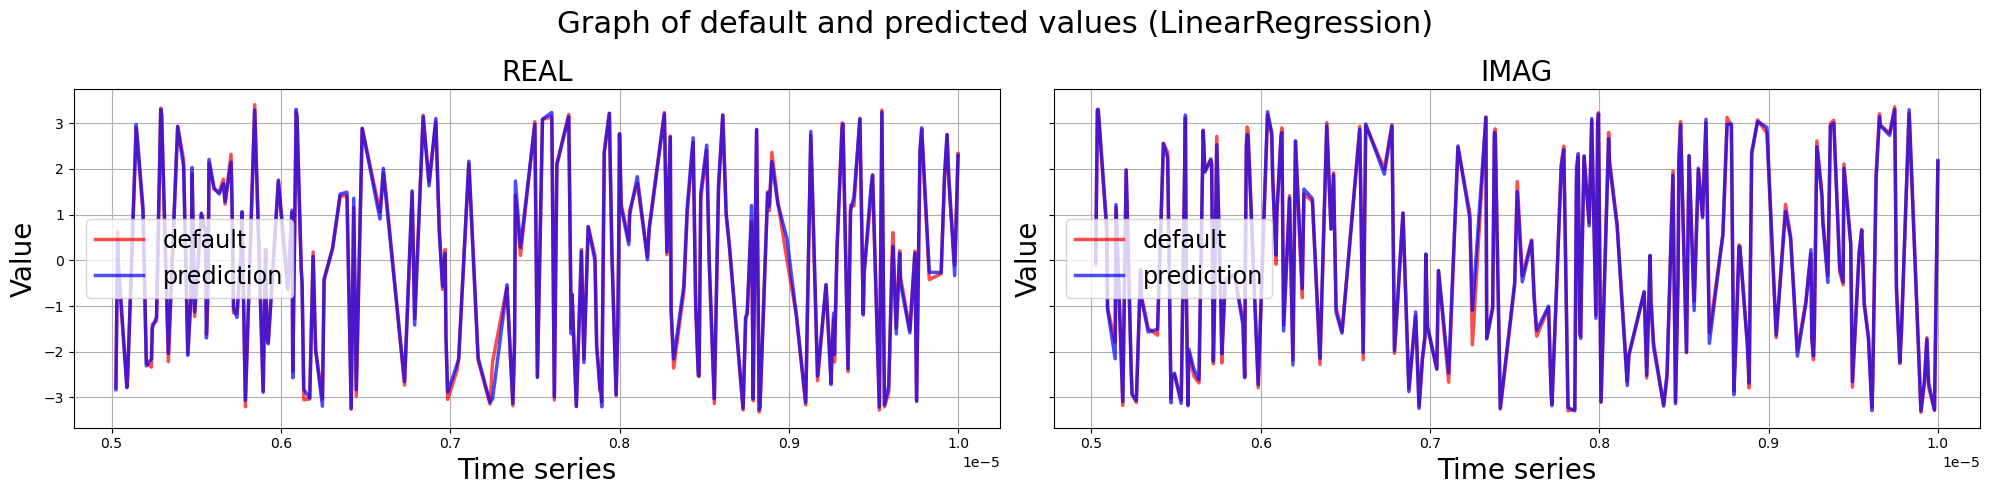

In [98]:
plot_predictions_vs_real(info_result, time_start=0.5e-5, time_end=1e-5)